In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import to_tree, ClusterNode, dendrogram
from typing import Dict, Tuple, List, Union, Optional
from ete3 import Tree

BASE_PATH = "/".join(os.getcwd().split("/")) # base dire"ctory level

DATA_PATH = os.path.join(BASE_PATH, "../../../dowloads/")  # where I dump new data
COMP_PATH = os.path.join(DATA_PATH,"1KGvs1KG")

In [2]:
def get_window_dendrogram(w, idx, ymax = None, ymin = -.001):
    fig, ax = plt.subplots(1, figsize=(25,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    sch.set_link_color_palette(['darkgrey', 'grey','black'])
    Z=tree_complete[w][0]
    dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)
    #plt.xticks([])
    plt.xlim(left = -10)
    plt.ylim(bottom = ymin)
    if ymax is not None:
        plt.ylim(top = ymax)

    # plt.tick_params(
    # axis='x',          # changes apply to the x-axis
    # which='both',      # both major and minor ticks are affected
    # bottom=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    # labelbottom=False)


    leaf_x = [(x * 10)+5 for x in dg['leaves']]
    leaf_y = [0] * 131

    sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'anc':'grey'}

    lineage_dict = {}
    for i in range(len(idx)):
        lineage_dict[i]=idx[i]
        
    colors = {}
    for k in lineage_dict.keys():
        i = k*10 + 5
        c = lineage_dict[k]
        if c != 'anc':
            c = c[4:7]
        c = sub_pal[c]
        colors[i] = c

    new_colors = [colors[i] for i in leaf_x]

    # create new x for plotting leaves
    new_leaf_x = range(5,1315,10)
    plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10)
    
    plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
    plt.ylabel('Divergence\n', size = 14) # label of the y-axis
    plt.title(str(w))
    plt.show()
    return Z


def one_window_tree(dict3d, w, tree_summary, tree_complete, link_method, idx):
        window_df = dict_3d[w].loc[idx][idx]
        length = len(idx)
        array = window_df.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
        condensed = array[np.triu_indices(length, k = 1)]
        Z = sch.linkage(condensed, method = link_method)
        dendrogram = sch.dendrogram(Z, labels=idx)
        whole_tree = [Z, dendrogram]

        cluster_sample_IDs = dendrogram['leaves']
        cluster_IDs = dendrogram['leaves_color_list']
        clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

        cluster_IDs_list = []
        for key, value in sorted(clusters_dict.items()):
                cluster_IDs_list.append(value)

        top_tree_y = dendrogram['dcoord'][-1]
        window_stats = cluster_IDs_list + top_tree_y


        return window_stats, whole_tree

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Clustering with Ancestral

## Set Up

In [4]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % DATA_PATH,
                       index_col=0)
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "%s/dict_seq.p" % DATA_PATH, "rb" ) )
matrix_seq = pickle.load( open( "%s/matrix_seq.p" % DATA_PATH, "rb" ) )

dict_3d = pickle.load( open( "%s/dict_3d.p" % DATA_PATH, "rb" ) )
matrix_3d = pickle.load( open( "%s/matrix_3d.p" % DATA_PATH, "rb" ) )


windows_tuples = list(dict_3d.keys())

sub_pops = list(set(comp_list.sub1).union(comp_list.sub2))
sub_pal = dict.fromkeys(sub_pops)
amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
sub_pal['GBR'] = eur_pal[0]
sub_pal['FIN'] = eur_pal[1]
sub_pal['IBS'] = eur_pal[2]
sub_pal['CEU'] = eur_pal[3]
sub_pal['TSI'] = eur_pal[4]

sub_pal['PEL'] = amr_pal[0]
sub_pal['CLM'] = amr_pal[1]
sub_pal['MXL'] = amr_pal[2]
sub_pal['PUR'] = amr_pal[3]

sub_pal['CHB'] = eas_pal[0]
sub_pal['JPT'] = eas_pal[1]
sub_pal['CHS'] = eas_pal[2]
sub_pal['CDX'] = eas_pal[3]
sub_pal['KHV'] = eas_pal[4]

sub_pal['ITU'] = sas_pal[0]
sub_pal['PJL'] = sas_pal[1]
sub_pal['BEB'] = sas_pal[2]
sub_pal['STU'] = sas_pal[3]
sub_pal['GIH'] = sas_pal[4]

sub_pal['ASW'] = afr_pal[0]
sub_pal['ACB'] = afr_pal[1]
sub_pal['GWD'] = afr_pal[2]
sub_pal['LWK'] = afr_pal[3]
sub_pal['ESN'] = afr_pal[4]
sub_pal['YRI'] = afr_pal[5]
sub_pal['MSL'] = afr_pal[6]

sub_pal['anc'] = 'grey'

In [5]:
idx_wa = sorted(set(comp_list.ind1).union(comp_list.ind2))
idx = idx_wa + ['anc']

In [6]:

anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
anc_div.columns = ['_'.join(col) for col in anc_div.columns.values]
anc_div = anc_div[idx_wa]


In [7]:
for w in dict_3d.keys():
    b = anc_div.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'anc'})
    a = dict_3d[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['anc'] = b.T['anc']

    dict_3d[w] = a

In [8]:
sub_idx = []
for i in idx:
    sub_idx.append(i[4:7])
sub_idx = sub_idx[:-1]
sub_idx.append('anc')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


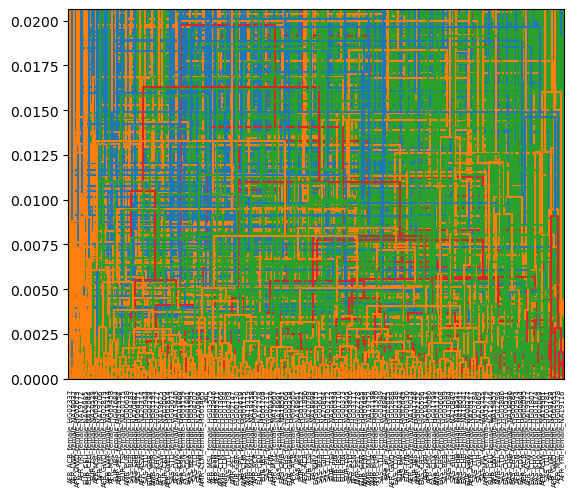

In [9]:
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=idx)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)


## Genome Avg

In [10]:
b = pd.DataFrame(anc_div.mean(), columns=['anc'])
a = matrix_3d.copy()
a = a[idx_wa].loc[idx_wa].append(b['anc'])
a['anc'] = b['anc']

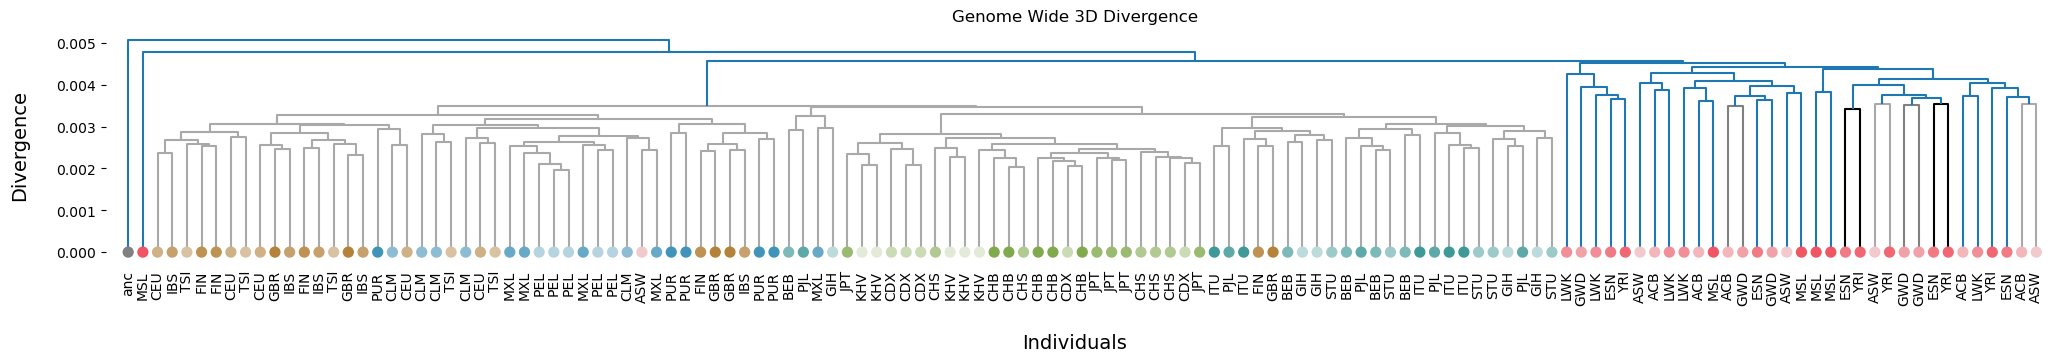

In [11]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0002)
# plt.tick_params(
# axis='x',          # changes apply to the x-axis
# which='both',      # both major and minor ticks are affected
# bottom=False,      # ticks along the bottom edge are off
# top=False,         # ticks along the top edge are off
# labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 131

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'anc':'grey'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if c != 'anc':
        c = c[4:7]
    c = sub_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1315,10)
plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide 3D Divergence')
plt.show()

In [12]:
avg_tree = Z

## Windows

In [13]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=list(idx) + ['coord_0','coord_1','coord_2','coord_3'])

counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']


### IDWs

In [14]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)|(counts_df.C5==1)]

In [15]:
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [16]:
len(idw_list)

1272

In [17]:
idw['individual'] = idw_list

In [18]:
idw.individual.value_counts().head(n=50)

anc                       65
AFR_LWK_female_NA19446    24
AFR_ASW_female_NA19917    22
AFR_ACB_female_HG01896    22
AFR_MSL_female_HG03378    21
AFR_ASW_female_NA19901    21
AFR_MSL_female_HG03086    20
AFR_GWD_female_HG02679    20
AFR_LWK_female_NA19314    20
AFR_GWD_female_HG02635    19
AFR_ACB_female_HG02555    19
AFR_ESN_female_HG02974    18
AFR_LWK_female_NA19037    18
AFR_ESN_female_HG03111    18
AFR_MSL_female_HG03458    18
AFR_YRI_female_NA19172    17
AFR_LWK_female_NA19457    17
AFR_MSL_female_HG03575    17
AFR_GWD_female_HG02888    17
SAS_ITU_female_HG03772    17
AFR_MSL_female_HG03583    17
AFR_LWK_female_NA19024    16
AFR_YRI_female_NA19116    16
AFR_ESN_female_HG03159    15
SAS_STU_female_HG03673    15
SAS_PJL_female_HG02655    14
EAS_KHV_female_HG01874    14
EAS_KHV_female_HG02069    14
EAS_KHV_female_HG01869    13
AMR_PUR_female_HG01191    13
AFR_GWD_female_HG02879    13
SAS_BEB_female_HG03611    13
AMR_PUR_female_HG01326    13
AFR_GWD_female_HG02814    12
SAS_STU_female

Text(0, 0.5, 'window count')

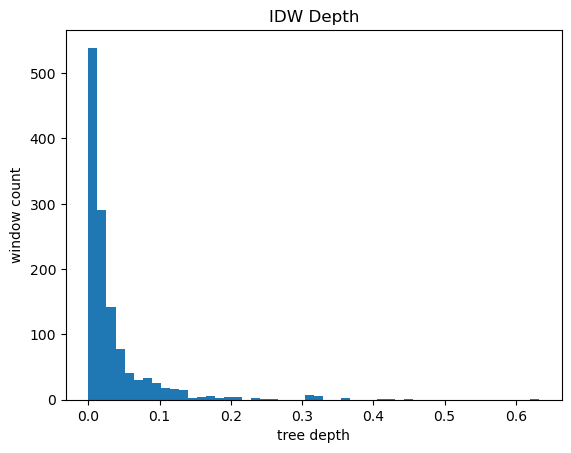

In [19]:
plt.hist(idw.depth, bins=50)
plt.title("IDW Depth")
plt.xlabel("tree depth")
plt.ylabel("window count")

In [20]:
def get_super_pop(idw_row):
    return idw_row.individual.split('_')[0]
    

In [21]:
idw_counts = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS','anc'])
for key in idw_counts.keys():
    idw_counts[key] = 0

for i in range(idw.shape[0]):
    super_pop = get_super_pop(idw.iloc[i])
    idw_counts[super_pop] += 1

In [22]:
idw[idw.individual=='anc']

,C0,C1,C2,C3,C4,C5,depth,individual
"(chr1, 67108864)",1.0,6.0,124.0,0.0,0.0,0.0,0.003538,anc
"(chr1, 168820736)",1.0,29.0,101.0,0.0,0.0,0.0,0.015923,anc
"(chr1, 169345024)",1.0,101.0,29.0,0.0,0.0,0.0,0.015162,anc
"(chr1, 192937984)",1.0,39.0,91.0,0.0,0.0,0.0,0.027680,anc
"(chr2, 108003328)",1.0,130.0,0.0,0.0,0.0,0.0,0.016311,anc
...,...,...,...,...,...,...,...,...
"(chr17, 65011712)",1.0,90.0,2.0,38.0,0.0,0.0,0.003880,anc
"(chr17, 80216064)",1.0,30.0,100.0,0.0,0.0,0.0,0.008849,anc
"(chr19, 9961472)",1.0,130.0,0.0,0.0,0.0,0.0,0.017462,anc
"(chr19, 30932992)",1.0,130.0,0.0,0.0,0.0,0.0,0.104280,anc


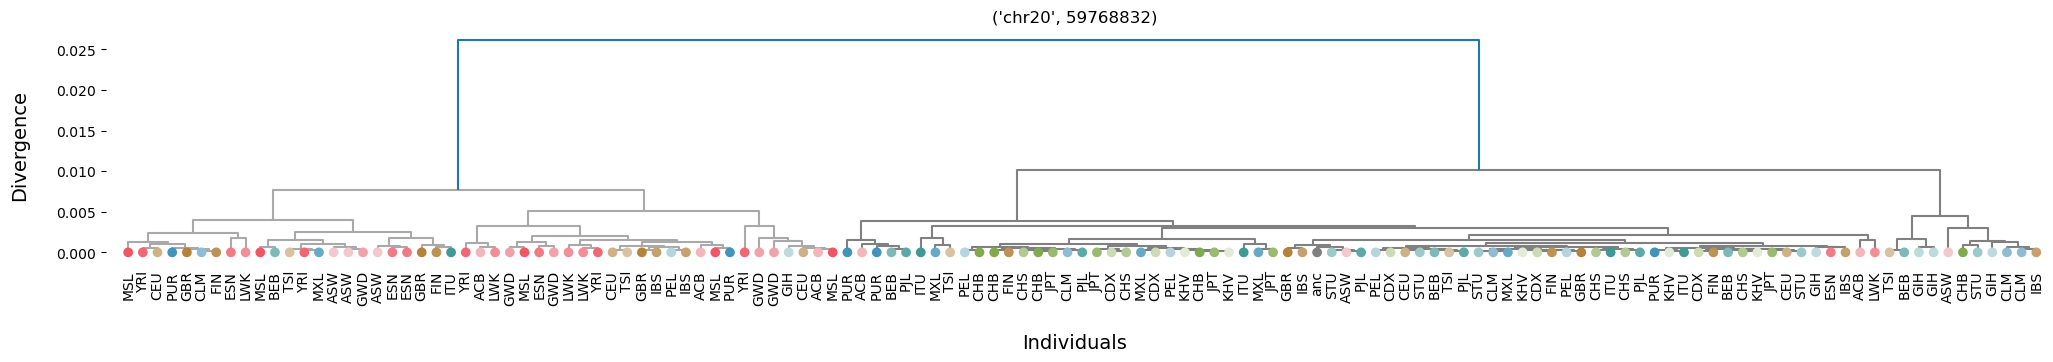

array([[8.00000000e+00, 1.23000000e+02, 1.24190794e-04, 2.00000000e+00],
       [6.90000000e+01, 7.70000000e+01, 1.33305492e-04, 2.00000000e+00],
       [5.50000000e+01, 8.90000000e+01, 1.45305392e-04, 2.00000000e+00],
       [3.90000000e+01, 4.30000000e+01, 1.49680289e-04, 2.00000000e+00],
       [7.50000000e+01, 1.19000000e+02, 1.60606482e-04, 2.00000000e+00],
       [7.30000000e+01, 7.90000000e+01, 1.64866480e-04, 2.00000000e+00],
       [1.00000000e+02, 1.22000000e+02, 1.70700706e-04, 2.00000000e+00],
       [5.80000000e+01, 8.70000000e+01, 1.80118588e-04, 2.00000000e+00],
       [6.40000000e+01, 1.36000000e+02, 1.88813733e-04, 3.00000000e+00],
       [4.60000000e+01, 9.00000000e+01, 1.94076790e-04, 2.00000000e+00],
       [8.40000000e+01, 1.25000000e+02, 2.00869716e-04, 2.00000000e+00],
       [5.90000000e+01, 6.60000000e+01, 2.06402778e-04, 2.00000000e+00],
       [6.20000000e+01, 7.10000000e+01, 2.06452089e-04, 2.00000000e+00],
       [1.28000000e+02, 1.34000000e+02, 2.07027159e

In [23]:
get_window_dendrogram(('chr20', 59768832), idx)

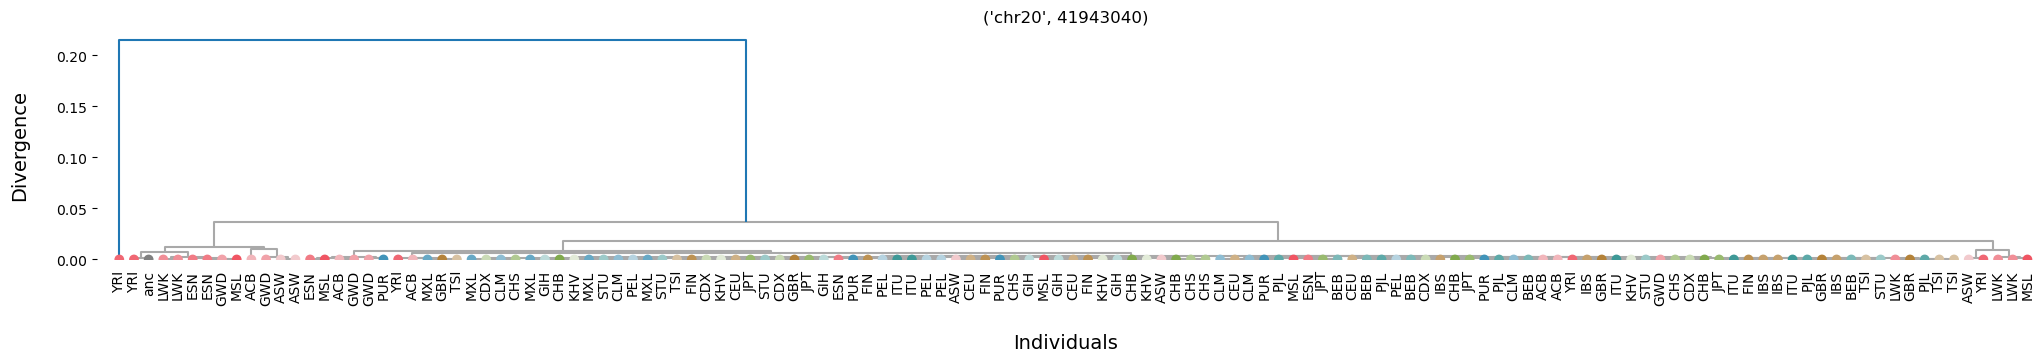

array([[3.60000000e+01, 4.70000000e+01, 1.11490745e-04, 2.00000000e+00],
       [5.70000000e+01, 6.00000000e+01, 1.19458770e-04, 2.00000000e+00],
       [9.80000000e+01, 9.90000000e+01, 1.27664777e-04, 2.00000000e+00],
       [5.60000000e+01, 9.40000000e+01, 1.57853336e-04, 2.00000000e+00],
       [4.90000000e+01, 1.09000000e+02, 1.76829031e-04, 2.00000000e+00],
       [1.16000000e+02, 1.22000000e+02, 1.82370475e-04, 2.00000000e+00],
       [6.40000000e+01, 7.90000000e+01, 2.03566619e-04, 2.00000000e+00],
       [6.30000000e+01, 7.50000000e+01, 2.03675974e-04, 2.00000000e+00],
       [4.60000000e+01, 1.17000000e+02, 2.08984595e-04, 2.00000000e+00],
       [1.27000000e+02, 1.31000000e+02, 2.09487630e-04, 3.00000000e+00],
       [9.20000000e+01, 1.04000000e+02, 2.13457135e-04, 2.00000000e+00],
       [7.20000000e+01, 1.13000000e+02, 2.14093821e-04, 2.00000000e+00],
       [3.70000000e+01, 1.08000000e+02, 2.36895935e-04, 2.00000000e+00],
       [5.20000000e+01, 1.24000000e+02, 2.38464897e

In [24]:
get_window_dendrogram(('chr20', 41943040), idx)

In [25]:
sum(idw_counts.values())

1272

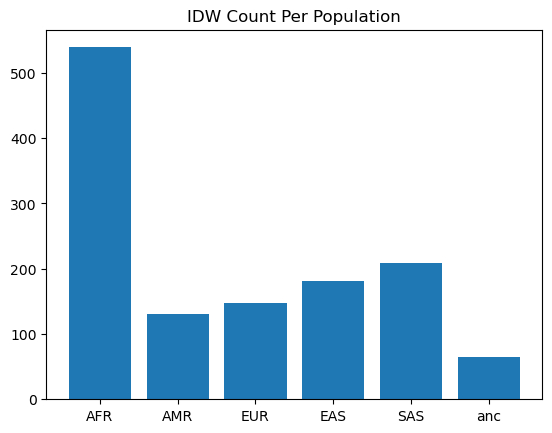

In [26]:
plt.bar(*zip(*idw_counts.items()))
plt.title('IDW Count Per Population')
plt.show()

### FDWs

In [27]:
fdw = counts_df[((counts_df.C0<=5 )& (counts_df.C0>=2 ))|
                ((counts_df.C0 == 0.0) & ((counts_df.C1<=5 )& (counts_df.C1>=2 )))
                # |
                # ((counts_df.C2<=5 )& (counts_df.C2>=2 ))|
                # ((counts_df.C3<=5 )& (counts_df.C3>=2 ))|
                # ((counts_df.C4<=5 )& (counts_df.C4>=2 ))|
                # ((counts_df.C5<=5 )& (counts_df.C5>=2 ))
                ]


In [28]:
def get_smallest_cluster(r, fdw):
    df = fdw.drop(columns=['depth'])
    fdw_row = df.loc[[r]]
    # idx = fdw_row.where(fdw_row != 0.0).dropna(axis=1).idxmin(axis=1).values[0]
    # size = fdw_row.where(fdw_row != 0.0).dropna(axis=1).min(axis=1).values[0]
    
    if fdw_row.C0.values[0] != 0.0:
        idx = 'C0'
    else:
        idx = 'C1'
    size = fdw_row[idx]
    return idx, size

def get_cluster_inds(cluster_id, window):
    inds = dataframe.loc[[window]].where(dataframe.loc[[window]]==cluster_id).dropna(axis=1).columns
    return list(inds)


def get_cluster_purity(df):
    pure_super_list=[]
    supers = []
    pure_sub_list=[]
    subs = []
    cluster_sizes = []
    num_clusters = []
    cs = counts_df[['C0','C1','C2','C3','C4','C5']]
    for row in df.index:
        w = row
        c_n = cs.loc[[w]].where(cs.loc[[w]]!=0.0).dropna(axis=1).shape[1]
        c = get_smallest_cluster(w, df)
        c_id = c[0]
        c_size = int(c[1])
        inds = get_cluster_inds(c_id,w)
        super_pop = inds[0][:3]
        sub_pop = inds[0][4:7]
        pure_super = all(item.startswith(super_pop) for item in inds)
        pure_sub = all(item[4:7]==sub_pop for item in inds)
        pure_super_list.append(pure_super)
        pure_sub_list.append(pure_sub)

        cluster_sizes.append(c_size)
        num_clusters.append(c_n)
        if pure_super:
            supers.append(super_pop)
        else:
            supers.append(np.nan)
        if pure_sub:
            subs.append(sub_pop)
        else:
            subs.append(np.nan)
    df['pure_super'] = pure_super_list
    df['pure_sub'] = pure_sub_list

    df['super'] = supers
    df['sub'] = subs

    df['cluster_size'] = cluster_sizes
    df['num_clusters'] = num_clusters
    return df

    

In [29]:
fdw = get_cluster_purity(fdw)

Text(0.5, 1.0, 'Pure Subpop "Few" Driven Windows by Super Pop')

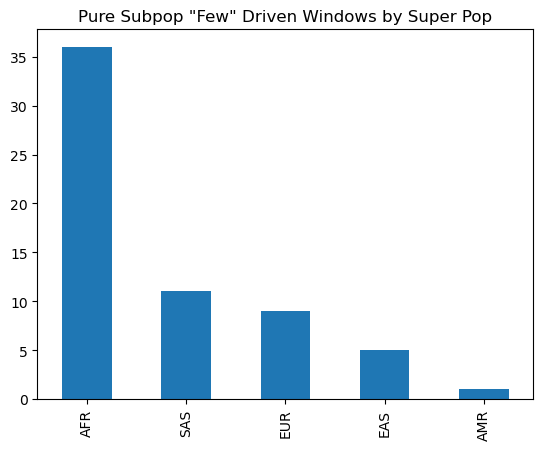

In [30]:
fdw[fdw.pure_sub==True].super.value_counts().plot.bar()
plt.title('Pure Subpop "Few" Driven Windows by Super Pop')

In [31]:
fdw[fdw.pure_sub==True].super.value_counts()

AFR    36
SAS    11
EUR     9
EAS     5
AMR     1
Name: super, dtype: int64

In [32]:
fdw

,C0,C1,C2,C3,C4,C5,depth,pure_super,pure_sub,super,sub,cluster_size,num_clusters
"(chr1, 4718592)",0.0,5.0,126.0,0.0,0.0,0.0,0.038550,True,False,AFR,NaN,5,2
"(chr1, 6815744)",2.0,129.0,0.0,0.0,0.0,0.0,0.007700,False,False,NaN,NaN,2,2
"(chr1, 9961472)",0.0,4.0,127.0,0.0,0.0,0.0,0.027768,True,False,EUR,NaN,4,2
"(chr1, 13107200)",0.0,4.0,127.0,0.0,0.0,0.0,0.015496,True,False,AFR,NaN,4,2
"(chr1, 13631488)",0.0,3.0,128.0,0.0,0.0,0.0,0.007033,True,False,AFR,NaN,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(chr22, 38797312)",0.0,2.0,129.0,0.0,0.0,0.0,0.004611,True,False,AFR,NaN,2,2
"(chr22, 39321600)",0.0,3.0,128.0,0.0,0.0,0.0,0.003940,False,False,NaN,NaN,3,2
"(chr22, 41418752)",0.0,2.0,9.0,120.0,0.0,0.0,0.003606,False,False,NaN,NaN,2,3
"(chr22, 44564480)",0.0,2.0,62.0,67.0,0.0,0.0,0.025806,False,False,NaN,NaN,2,3


In [33]:
fdw[fdw.pure_sub==True].super.value_counts().sum()

62

### Homogeneous windows

In [34]:
test = get_cluster_purity(counts_df)

In [35]:
test

,C0,C1,C2,C3,C4,C5,depth,pure_super,pure_sub,super,sub,cluster_size,num_clusters
"(chr1, 1048576)",0.0,96.0,23.0,12.0,0.0,0.0,0.007679,False,False,NaN,NaN,96,3
"(chr1, 1572864)",0.0,120.0,11.0,0.0,0.0,0.0,0.008876,False,False,NaN,NaN,120,2
"(chr1, 3145728)",0.0,45.0,6.0,80.0,0.0,0.0,0.019304,False,False,NaN,NaN,45,3
"(chr1, 3670016)",1.0,48.0,82.0,0.0,0.0,0.0,0.016704,True,True,AFR,ASW,1,3
"(chr1, 4194304)",0.0,48.0,83.0,0.0,0.0,0.0,0.028704,False,False,NaN,NaN,48,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(chr22, 46661632)",0.0,13.0,3.0,115.0,0.0,0.0,0.029379,False,False,NaN,NaN,13,3
"(chr22, 47185920)",1.0,130.0,0.0,0.0,0.0,0.0,0.328717,True,True,SAS,STU,1,2
"(chr22, 47710208)",1.0,7.0,123.0,0.0,0.0,0.0,0.145304,True,True,EAS,KHV,1,3
"(chr22, 48234496)",0.0,6.0,125.0,0.0,0.0,0.0,0.317616,False,False,NaN,NaN,6,2


Text(0.5, 1.0, 'Size of first cluster')

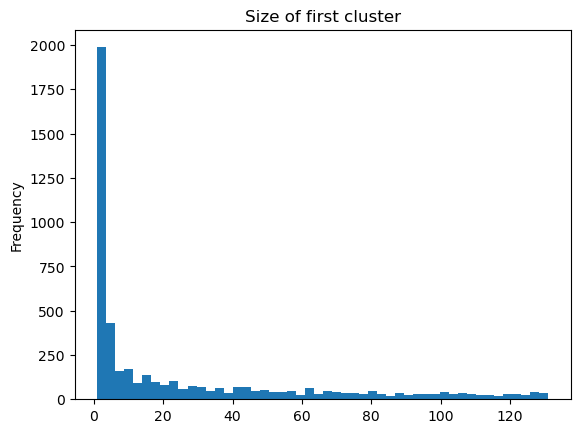

In [36]:
test.cluster_size.plot.hist(bins=50)
plt.title('Size of first cluster')

In [37]:
super_pure = test[test.pure_super]
sub_pure = test[test.pure_sub]

Text(0.5, 1.0, 'Homogeneous Cluster Size Distribution (super)')

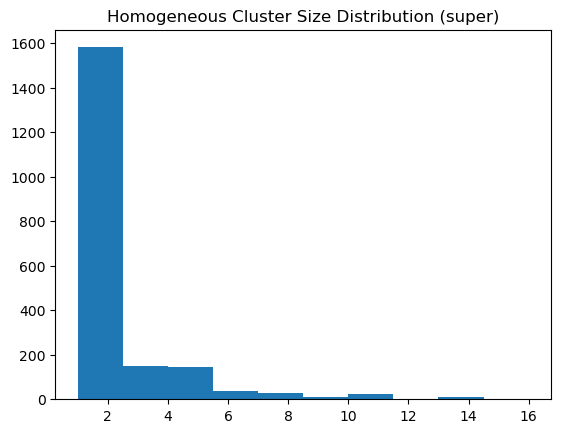

In [38]:
plt.hist(super_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (super)")

Text(0.5, 1.0, 'Homogeneous Cluster Size Distribution (sub)')

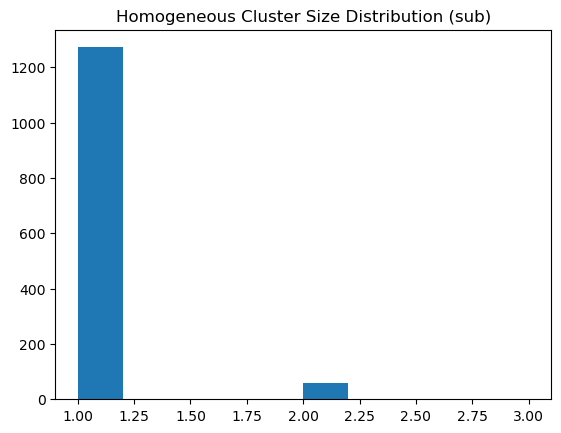

In [39]:
plt.hist(sub_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (sub)")

In [40]:
super_pure.loc[[super_pure.cluster_size.idxmax()]]

,C0,C1,C2,C3,C4,C5,depth,pure_super,pure_sub,super,sub,cluster_size,num_clusters
"(chr17, 52428800)",0.0,16.0,115.0,0.0,0.0,0.0,0.034665,True,False,AFR,NaN,16,2


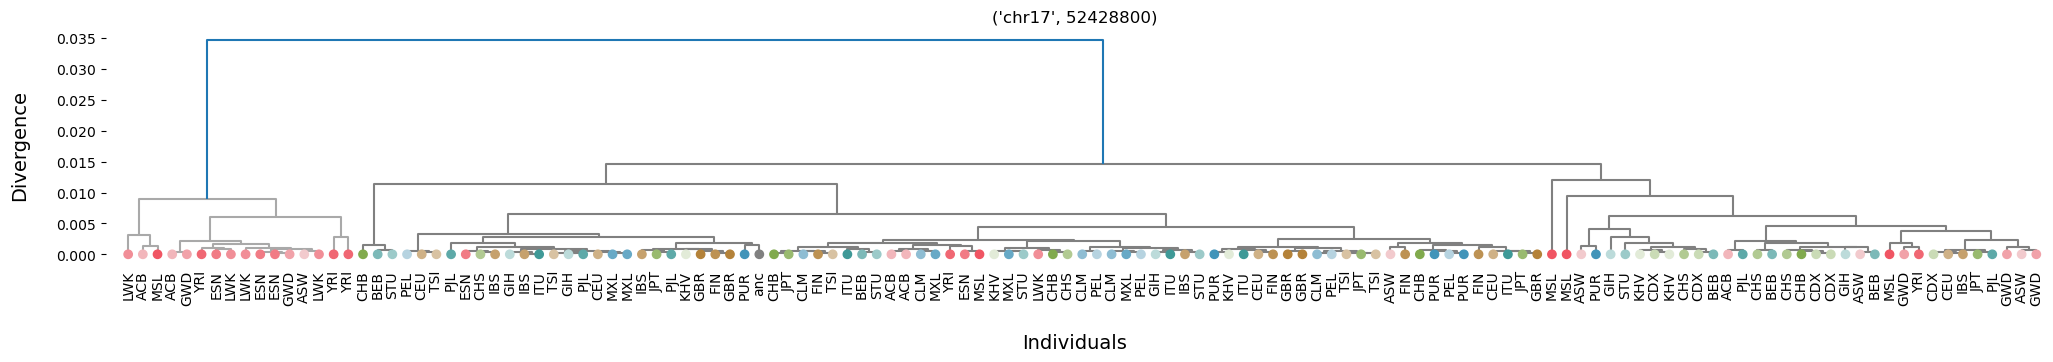

In [41]:
dendrogram = get_window_dendrogram(super_pure.cluster_size.idxmax(), idx)

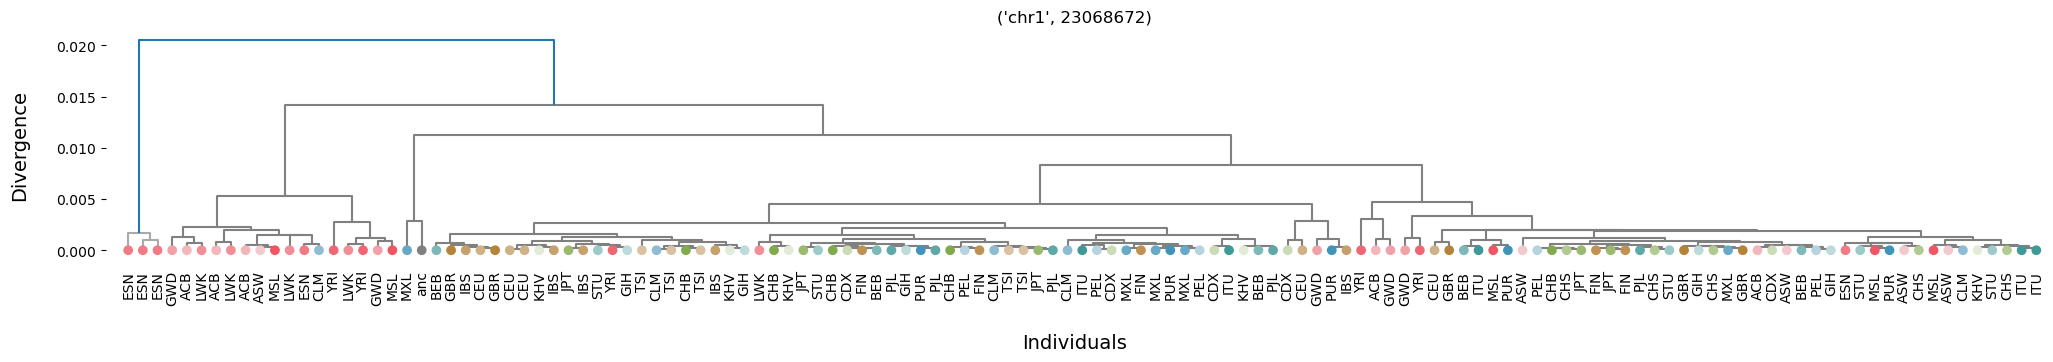

In [42]:
dendrogram = get_window_dendrogram(sub_pure.cluster_size.idxmax(), idx)

# ETE

## Convert to Newick

In [43]:
def _scipy_tree_to_newick_list(node: ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str]) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        newick.append(f'):{parentdist - node.dist}')
    else:
        newick.append(');')
    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names)
    newick.append('(')
    return newick


def to_newick(tree: ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names)
    return ''.join(newick_list[::-1])

In [44]:
trees = {}
for w in windows_tuples:
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    trees[w] = T
trees['avg'] = Tree(to_newick(hc.to_tree(Z), idx))

## Monophyletic?

In [45]:
pops = {key: [] for key in ['AFR','EUR','AMR','SAS','EAS','anc']}
for i in idx:
    pop = i[:3]
    pops[pop].append(i)


In [46]:
mono = pd.DataFrame(index = windows_tuples, columns = pops.keys())

In [47]:
pops['EAS']

['EAS_CDX_female_HG00864',
 'EAS_CDX_female_HG01799',
 'EAS_CDX_female_HG01801',
 'EAS_CDX_female_HG01807',
 'EAS_CDX_female_HG02188',
 'EAS_CHB_female_NA18531',
 'EAS_CHB_female_NA18541',
 'EAS_CHB_female_NA18591',
 'EAS_CHB_female_NA18596',
 'EAS_CHB_female_NA18631',
 'EAS_CHS_female_HG00531',
 'EAS_CHS_female_HG00566',
 'EAS_CHS_female_HG00584',
 'EAS_CHS_female_HG00596',
 'EAS_CHS_female_HG00608',
 'EAS_JPT_female_NA18951',
 'EAS_JPT_female_NA18981',
 'EAS_JPT_female_NA18991',
 'EAS_JPT_female_NA18998',
 'EAS_JPT_female_NA19084',
 'EAS_KHV_female_HG01869',
 'EAS_KHV_female_HG01874',
 'EAS_KHV_female_HG02069',
 'EAS_KHV_female_HG02075',
 'EAS_KHV_female_HG02127']

In [48]:
count = 1
for w in tree_complete.keys():
    print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in pops.keys():
        status = T.check_monophyly(values=pops[p], target_attr="name")[0]
        mono.at[w,p] = status
    count += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [49]:
mono[mono.eq(True).any(1)]

,AFR,EUR,AMR,SAS,EAS,anc
"(chr1, 122683392)",True,False,False,False,False,False
"(chr1, 123207680)",True,False,False,False,False,False
"(chr1, 123731968)",True,False,False,False,False,False
"(chr3, 92274688)",True,False,False,False,False,False
"(chr5, 47710208)",True,False,False,False,False,False
"(chr5, 48234496)",True,False,False,False,False,False
"(chr9, 43515904)",True,False,False,False,False,False
"(chr12, 35127296)",True,False,False,False,False,False
"(chr17, 23592960)",True,False,False,False,False,False
"(chr17, 24117248)",True,False,False,False,False,False


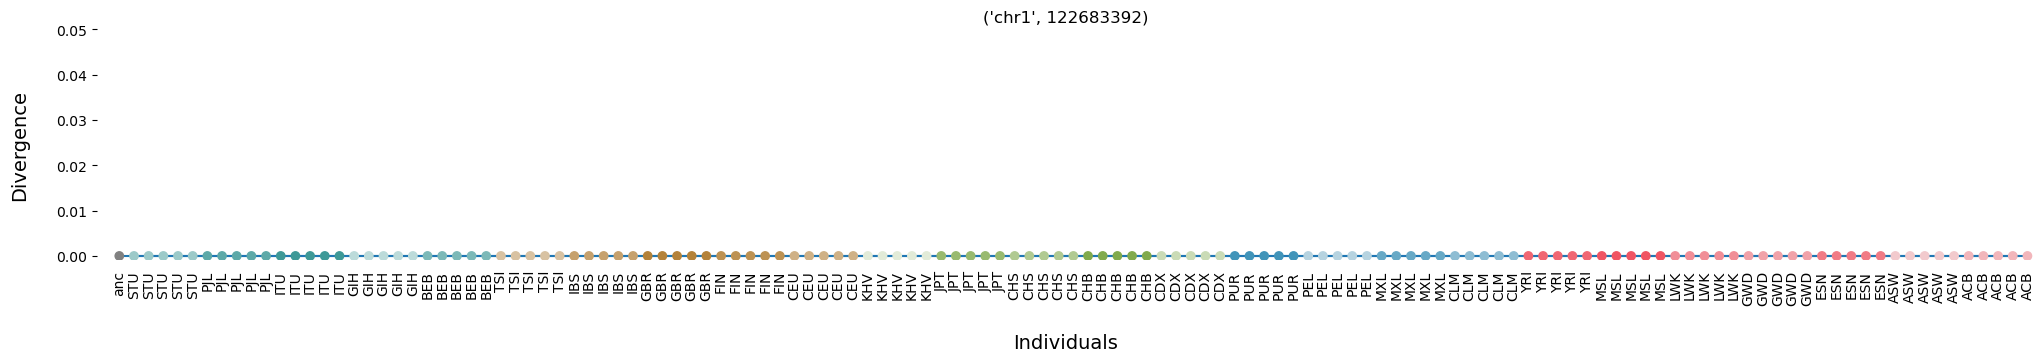

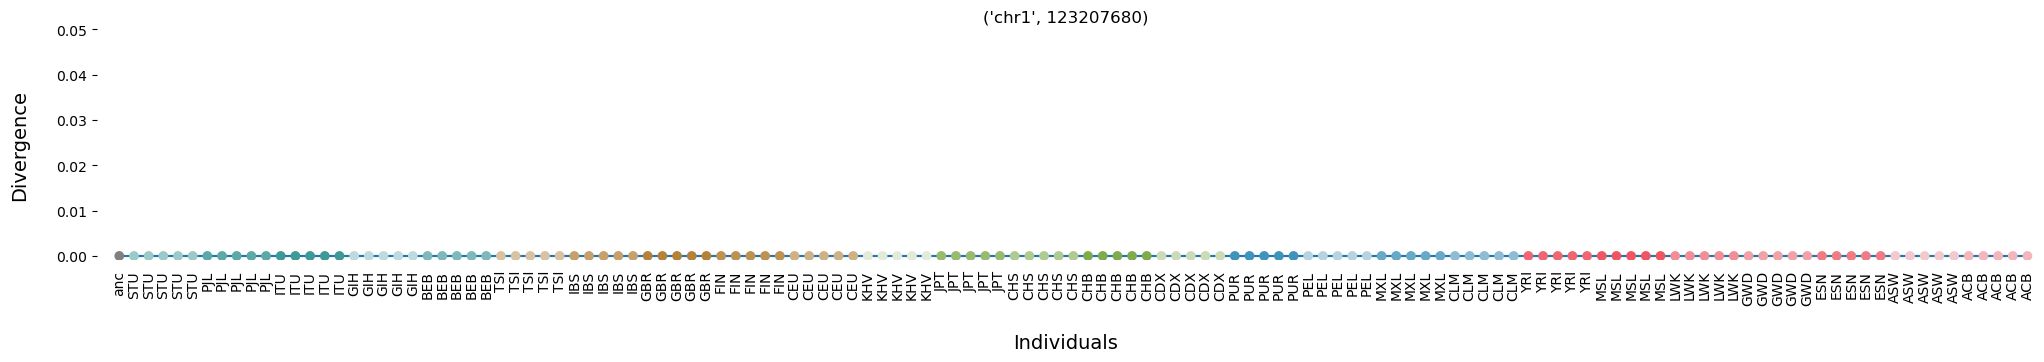

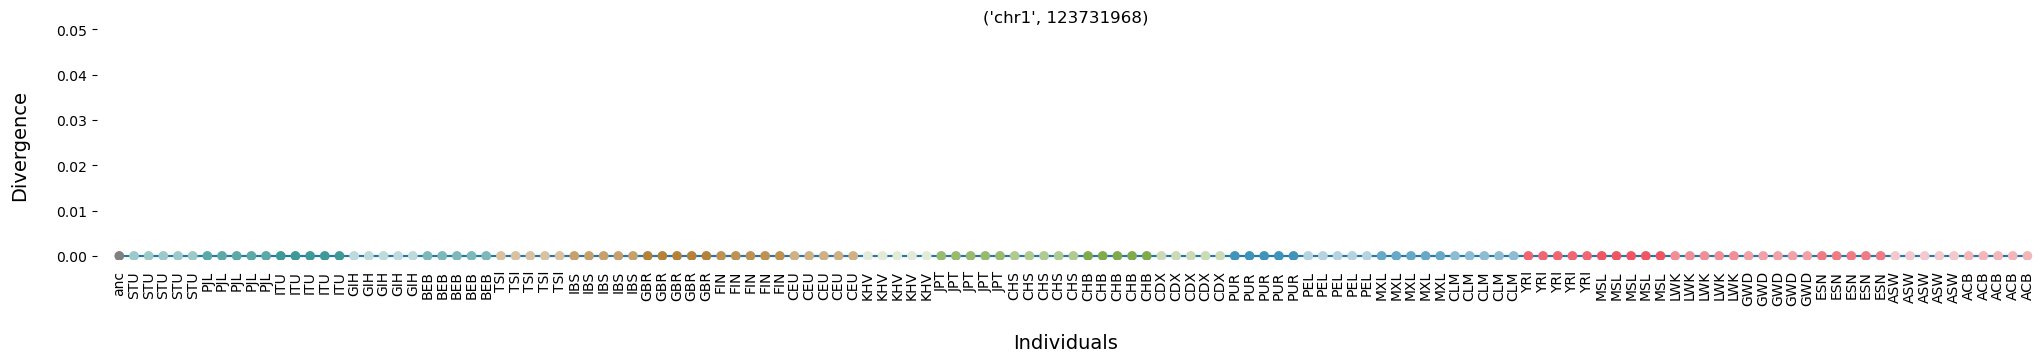

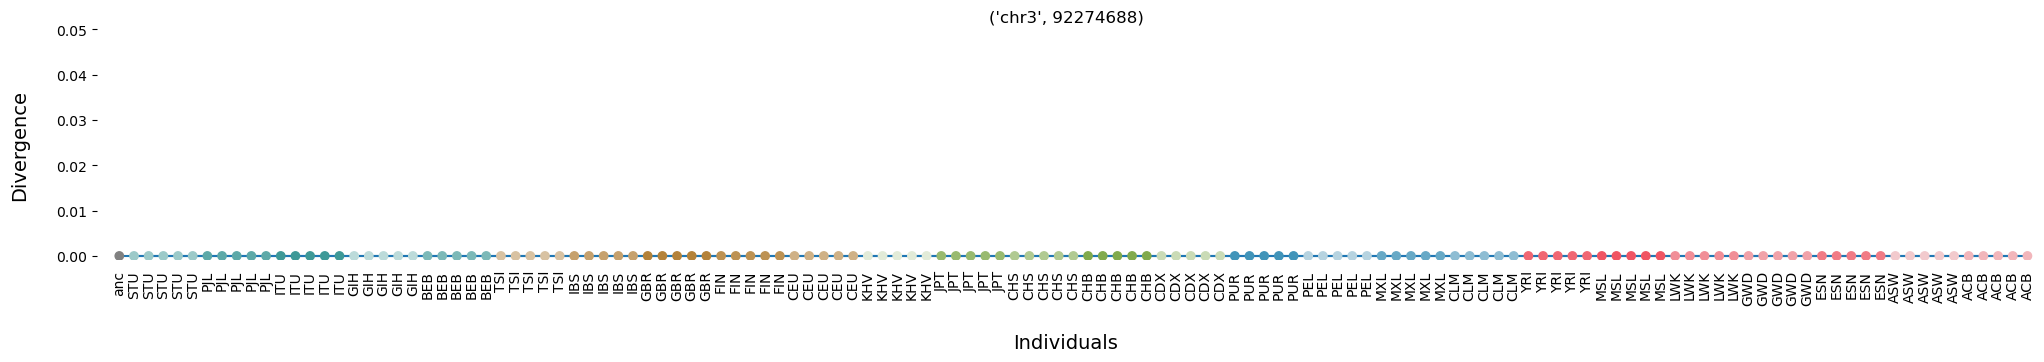

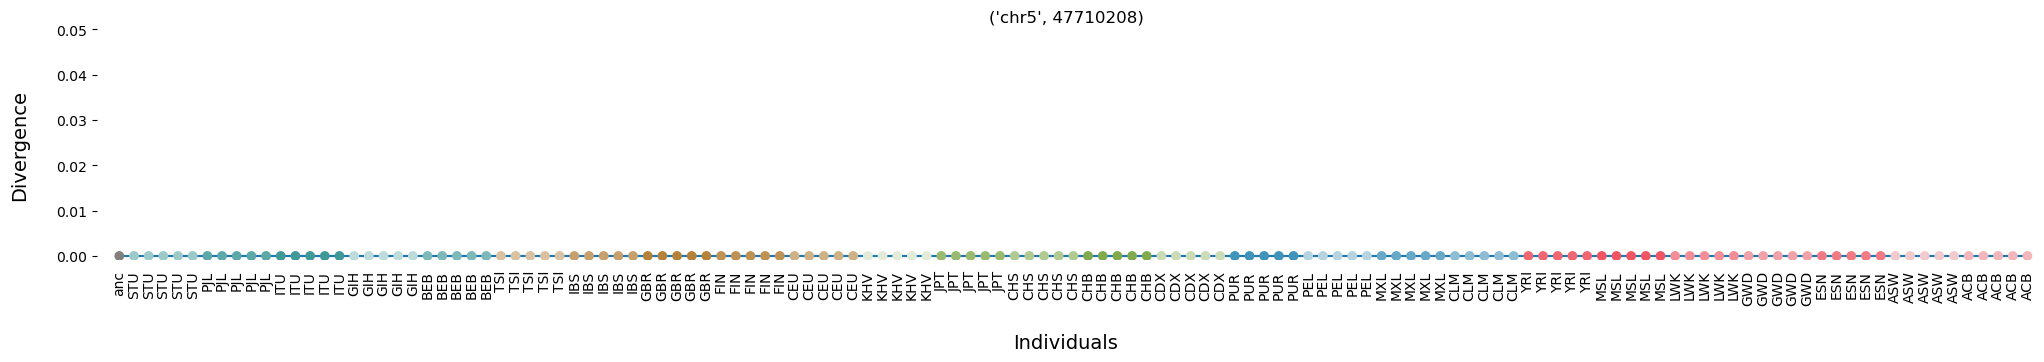

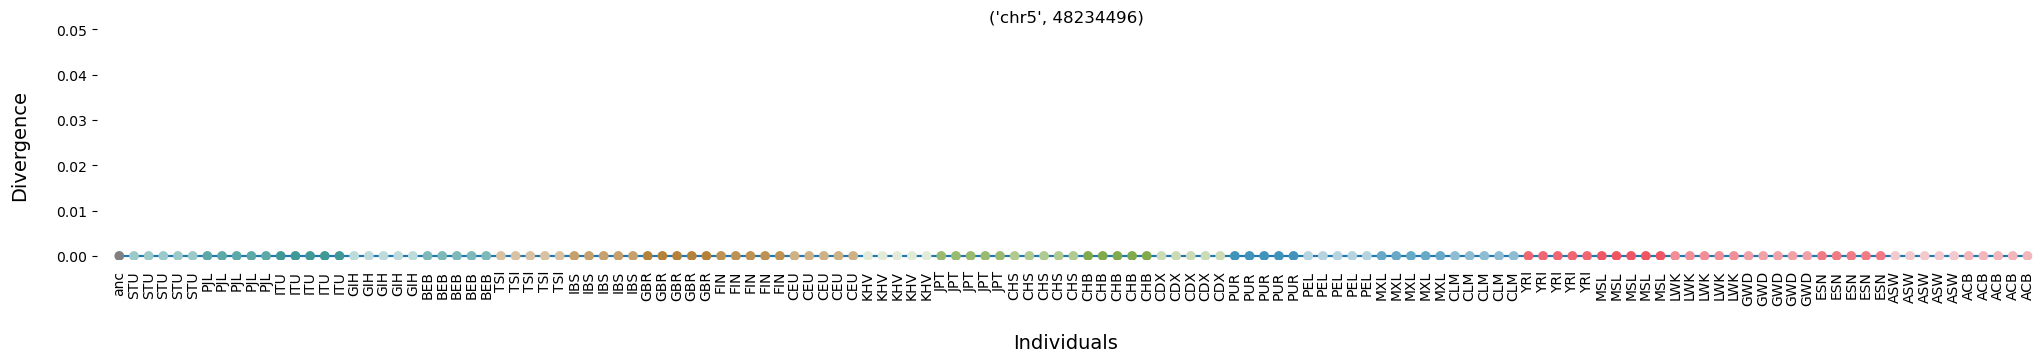

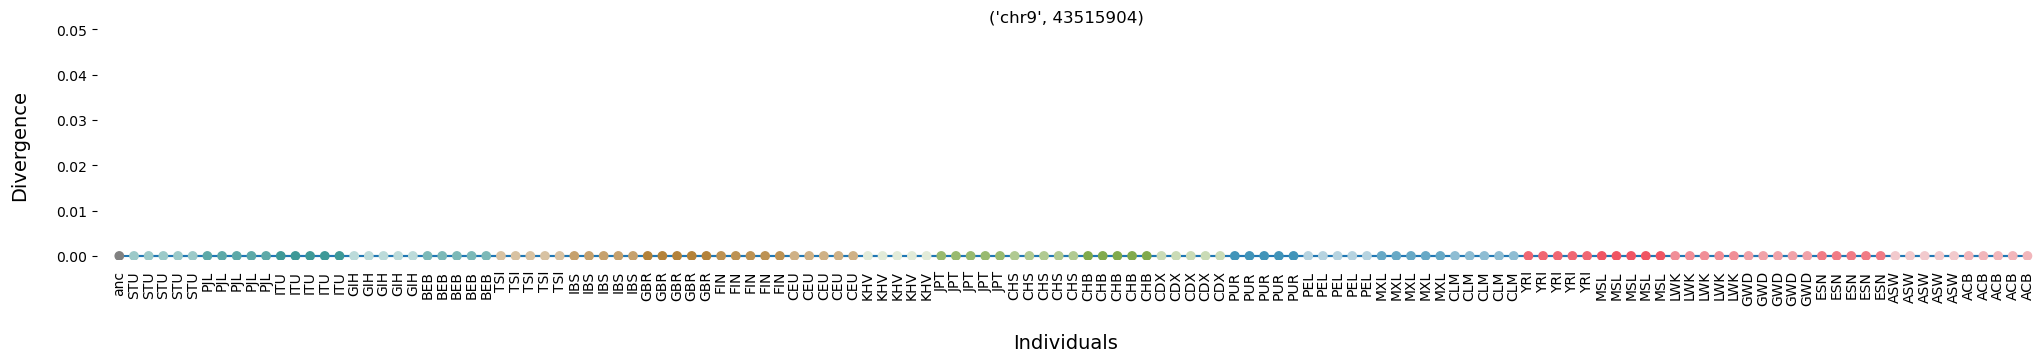

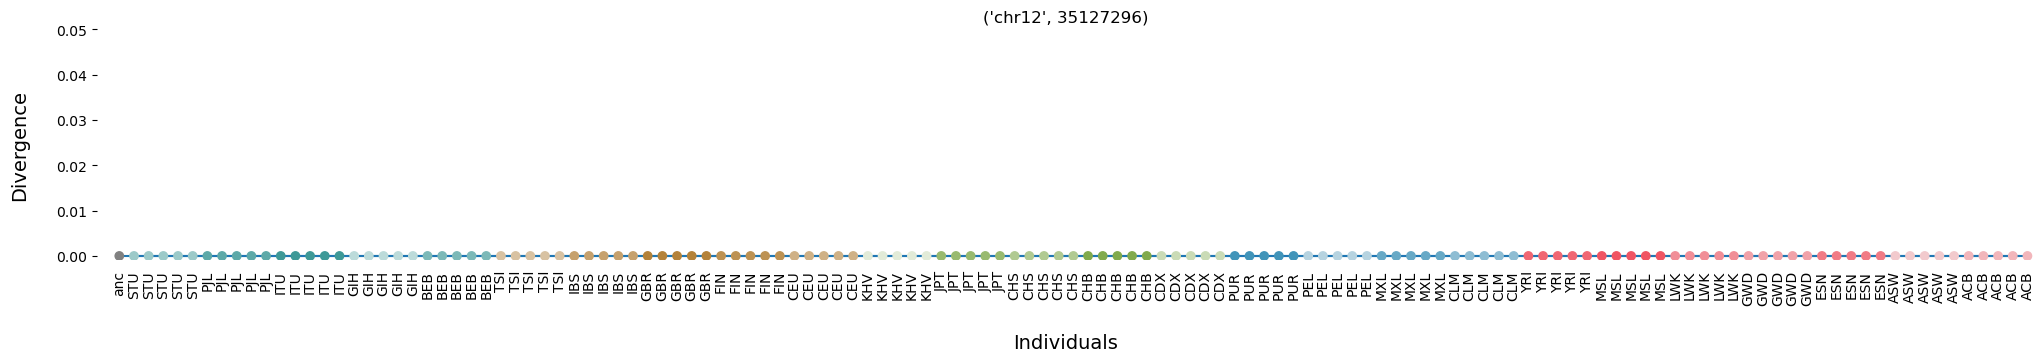

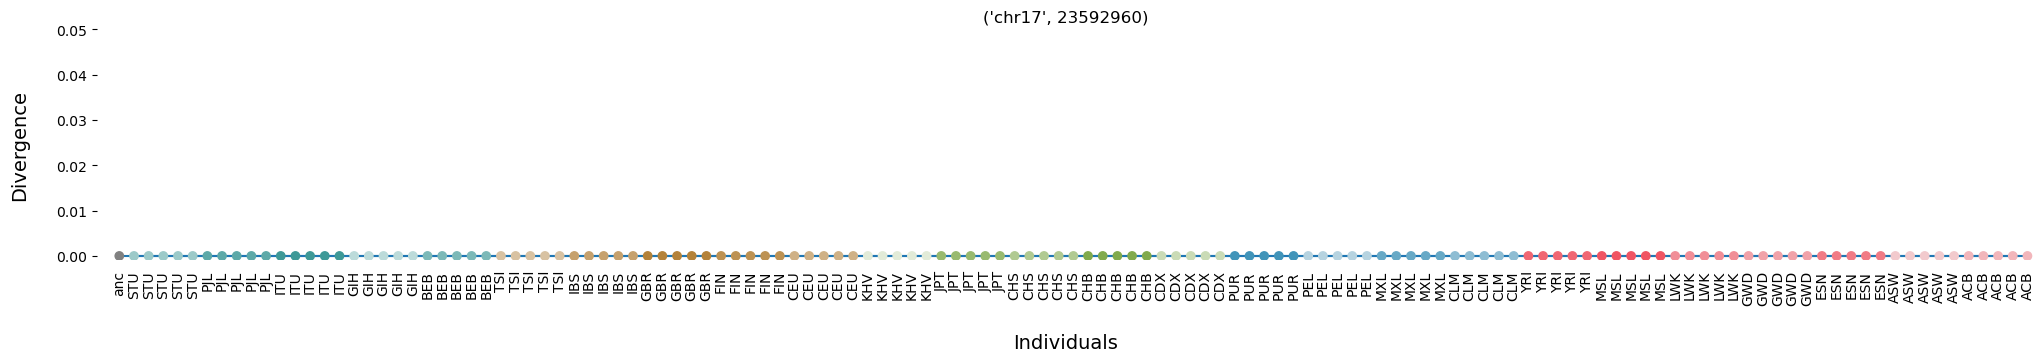

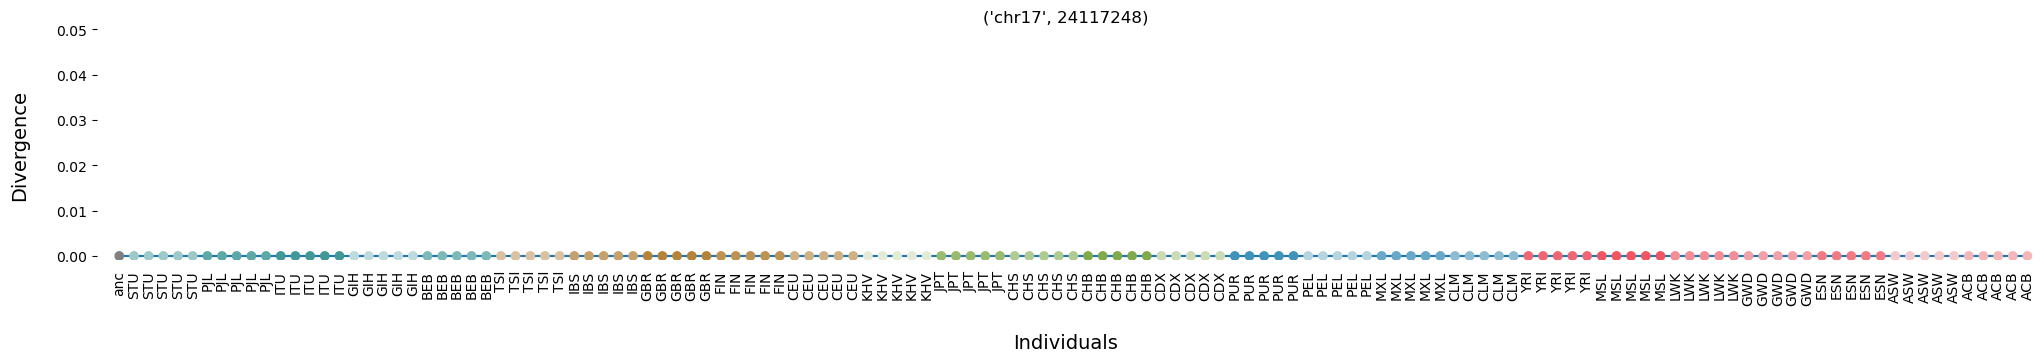

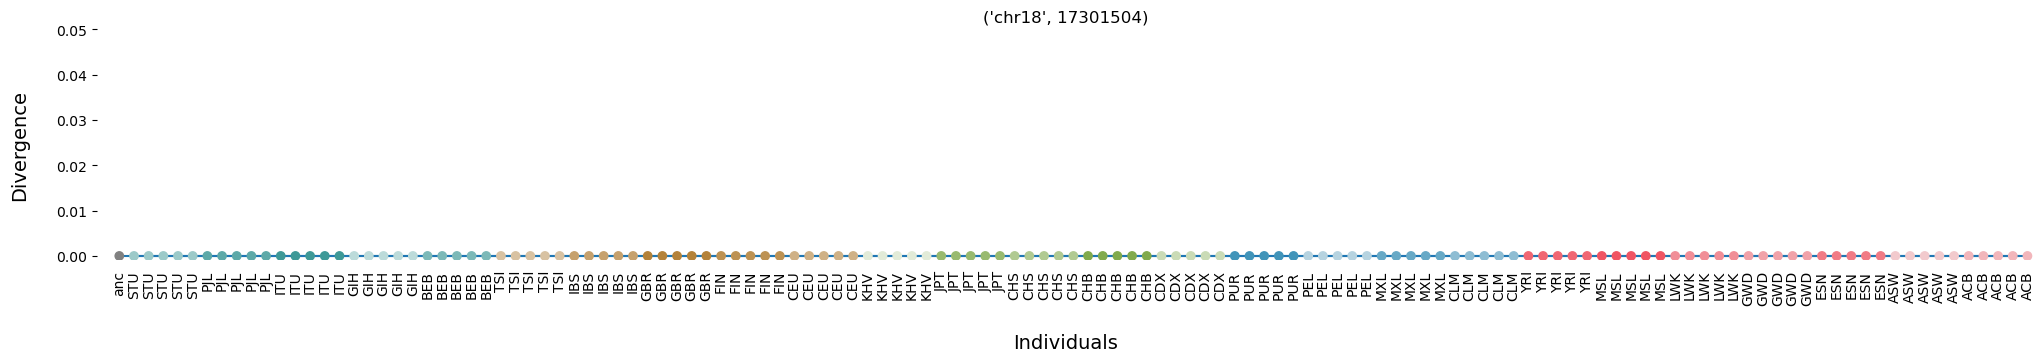

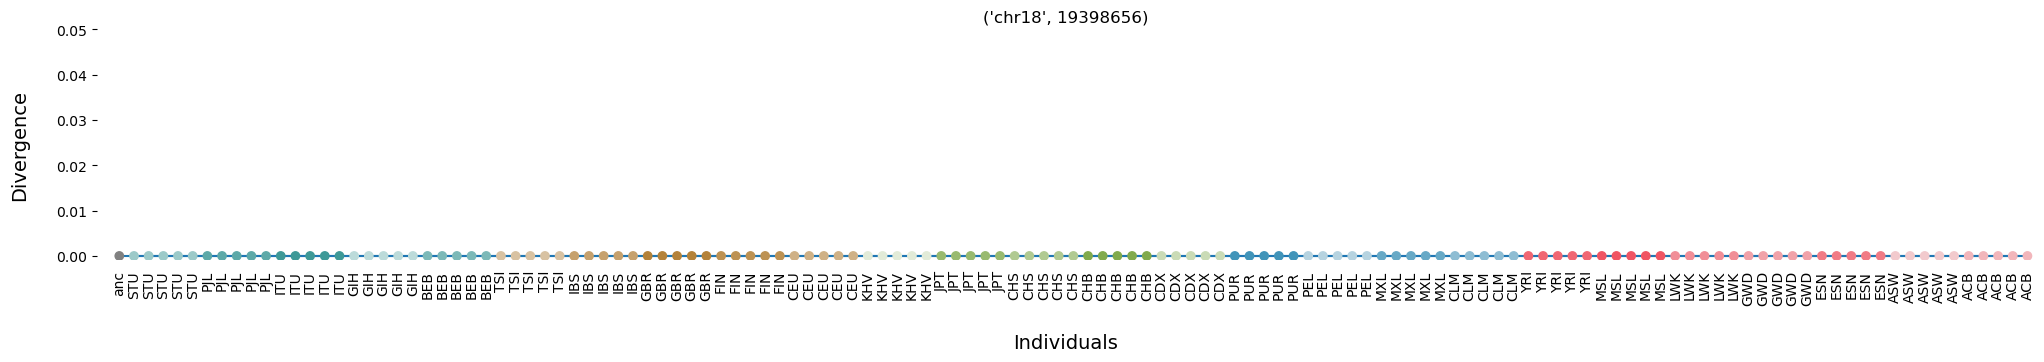

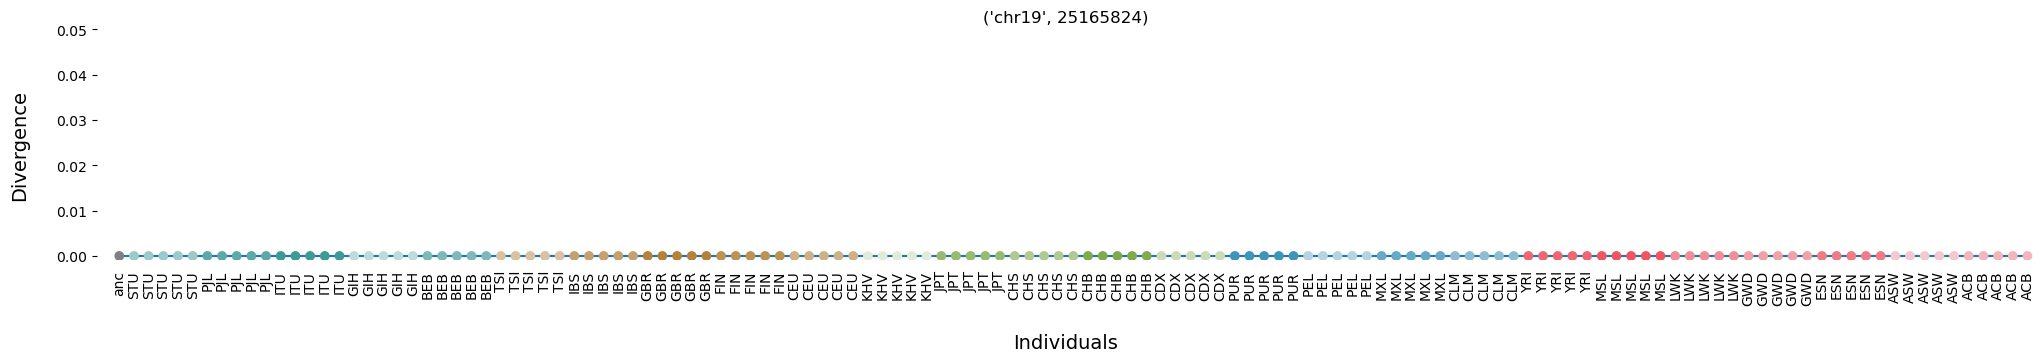

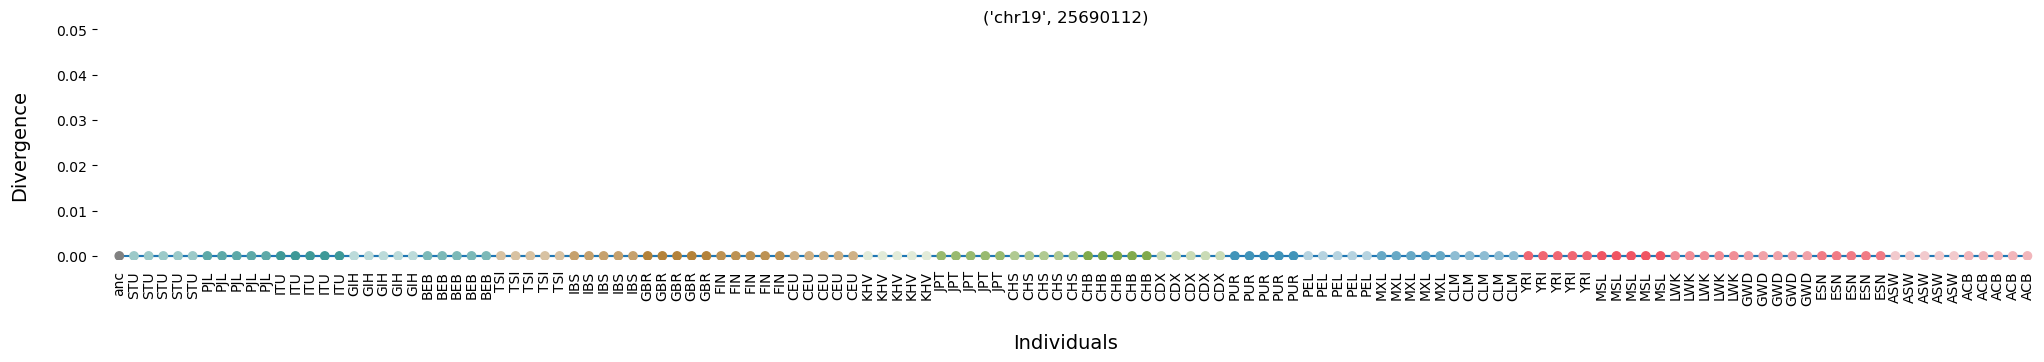

In [50]:
for w in mono[mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [51]:
mono[mono.anc==True]

,AFR,EUR,AMR,SAS,EAS,anc


In [52]:
test.loc[mono[mono.eq(True).any(1)].index]

,C0,C1,C2,C3,C4,C5,depth,pure_super,pure_sub,super,sub,cluster_size,num_clusters
"(chr1, 122683392)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr1, 123207680)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr1, 123731968)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr3, 92274688)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr5, 47710208)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr5, 48234496)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr9, 43515904)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr12, 35127296)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr17, 23592960)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1
"(chr17, 24117248)",131.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,NaN,NaN,131,1


In [53]:
sub_pops = {key: [] for key in sub_idx}
for i in idx:
    if i != 'anc':
        pop = i[4:7]
    else:
        pop = i
    sub_pops[pop].append(i)

In [54]:
sub_pops

{'ACB': ['AFR_ACB_female_HG01896',
  'AFR_ACB_female_HG02095',
  'AFR_ACB_female_HG02337',
  'AFR_ACB_female_HG02505',
  'AFR_ACB_female_HG02555'],
 'ASW': ['AFR_ASW_female_NA19625',
  'AFR_ASW_female_NA19901',
  'AFR_ASW_female_NA19917',
  'AFR_ASW_female_NA20314',
  'AFR_ASW_female_NA20317'],
 'ESN': ['AFR_ESN_female_HG02946',
  'AFR_ESN_female_HG02974',
  'AFR_ESN_female_HG03111',
  'AFR_ESN_female_HG03159',
  'AFR_ESN_female_HG03511'],
 'GWD': ['AFR_GWD_female_HG02635',
  'AFR_GWD_female_HG02679',
  'AFR_GWD_female_HG02814',
  'AFR_GWD_female_HG02879',
  'AFR_GWD_female_HG02888'],
 'LWK': ['AFR_LWK_female_NA19024',
  'AFR_LWK_female_NA19037',
  'AFR_LWK_female_NA19314',
  'AFR_LWK_female_NA19446',
  'AFR_LWK_female_NA19457'],
 'MSL': ['AFR_MSL_female_HG03086',
  'AFR_MSL_female_HG03378',
  'AFR_MSL_female_HG03458',
  'AFR_MSL_female_HG03575',
  'AFR_MSL_female_HG03583'],
 'YRI': ['AFR_YRI_female_NA19116',
  'AFR_YRI_female_NA19129',
  'AFR_YRI_female_NA19137',
  'AFR_YRI_female_NA1

In [55]:
sub_mono = pd.DataFrame(index = windows_tuples, columns = sub_pops.keys())
count = 0
for w in tree_complete.keys():
    if count%100 == 0:
        print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in sub_pops.keys():
        status = T.check_monophyly(values=sub_pops[p], target_attr="name")[0]
        sub_mono.at[w,p] = status
    count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


In [56]:
sub_mono[sub_mono.eq(True).any(1)]

,ACB,ASW,ESN,GWD,LWK,MSL,YRI,CLM,MXL,PEL,...,FIN,GBR,IBS,TSI,BEB,GIH,ITU,PJL,STU,anc
"(chr1, 122683392)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr1, 123207680)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr1, 123731968)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr3, 92274688)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr5, 47710208)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr5, 48234496)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr9, 43515904)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr12, 35127296)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr17, 23592960)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
"(chr17, 24117248)",True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


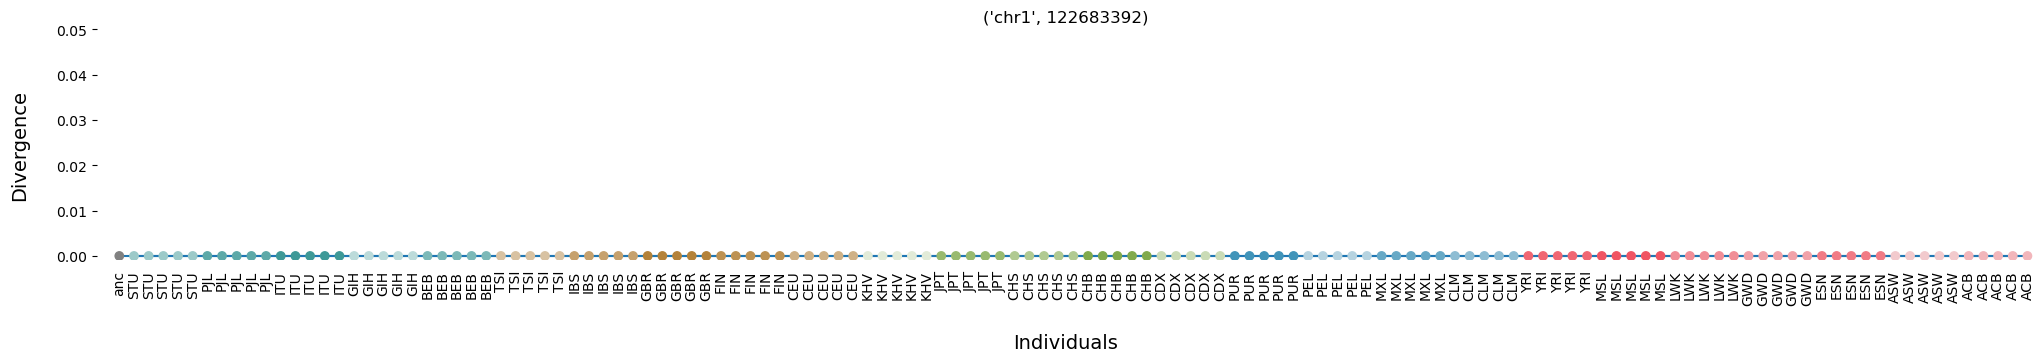

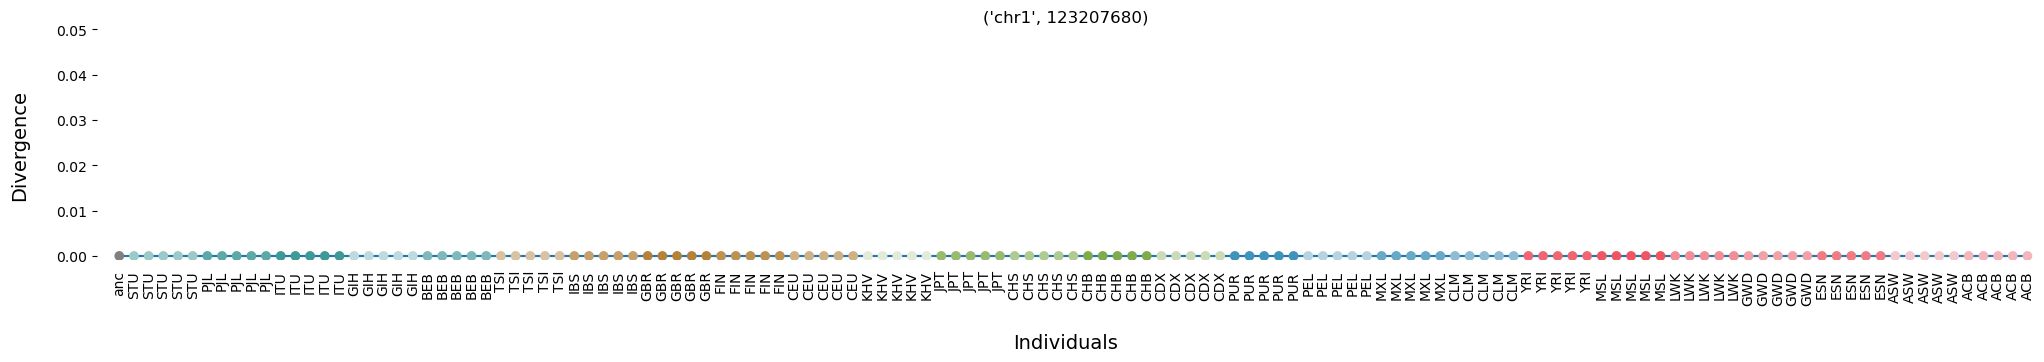

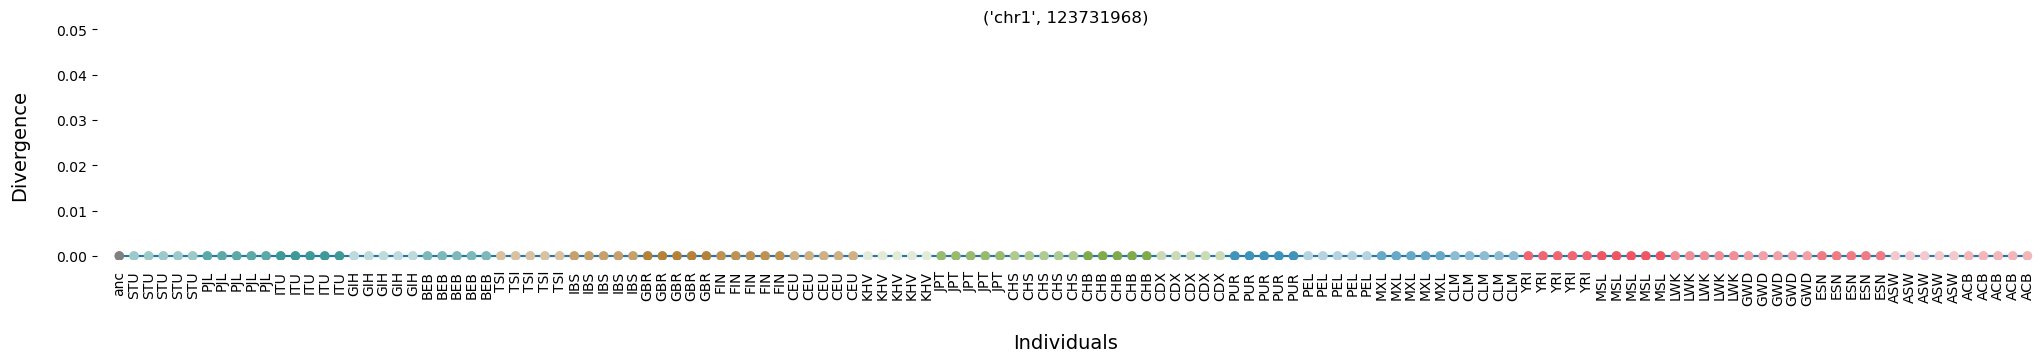

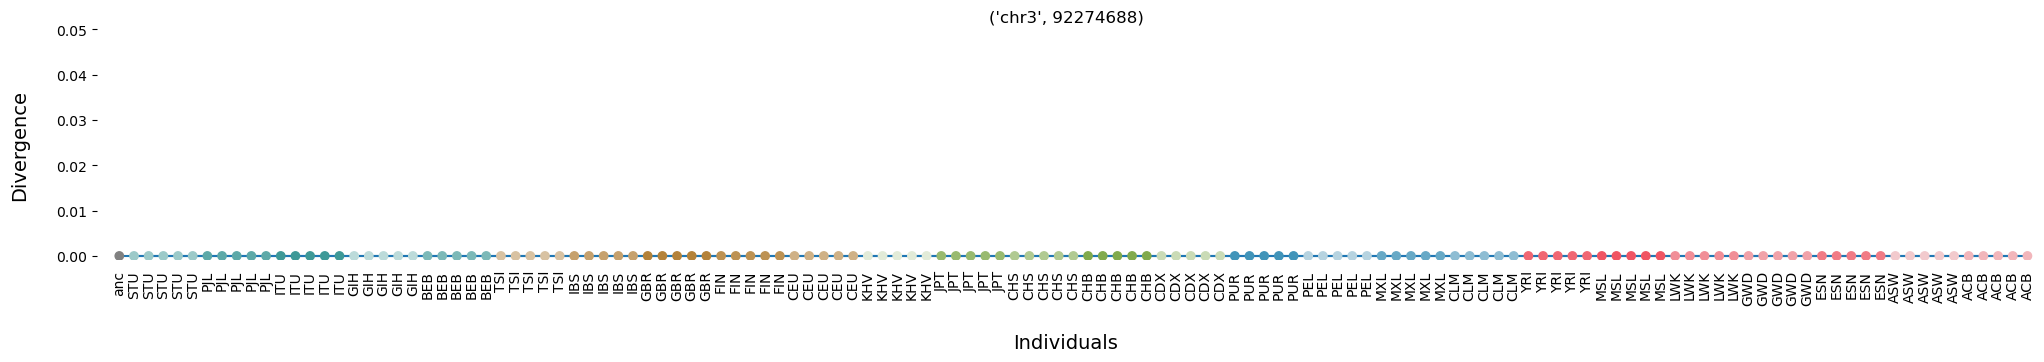

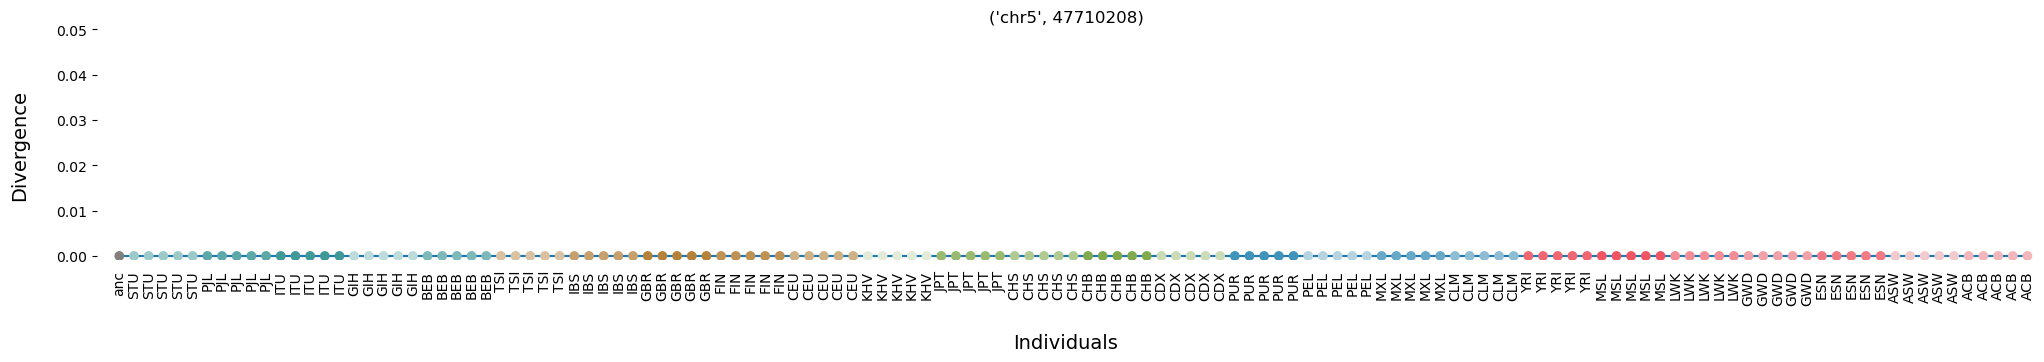

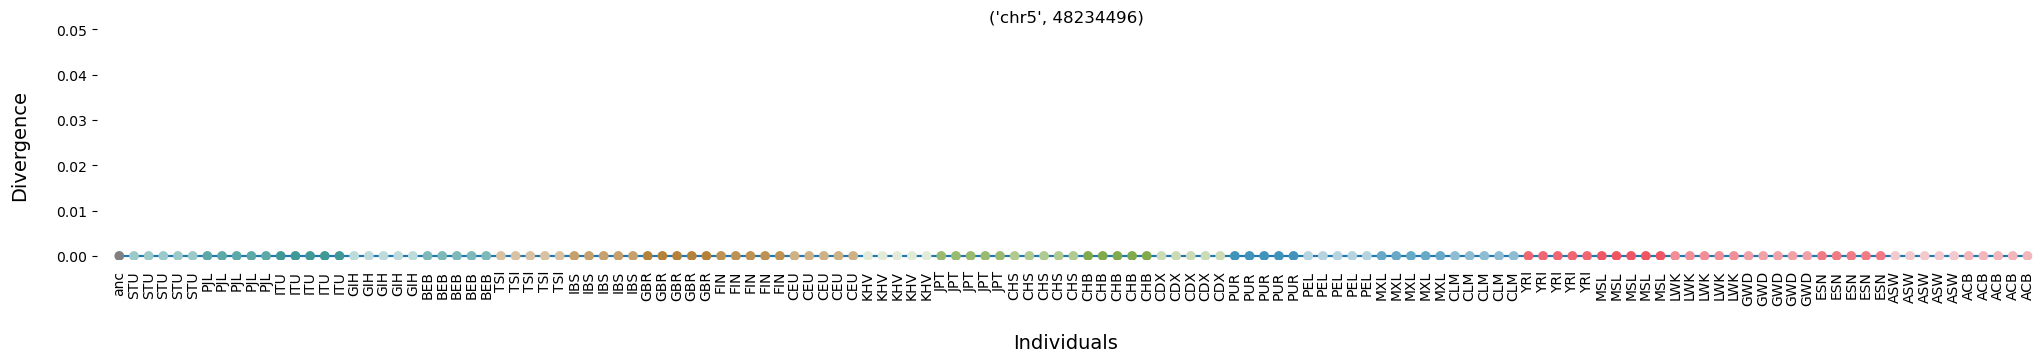

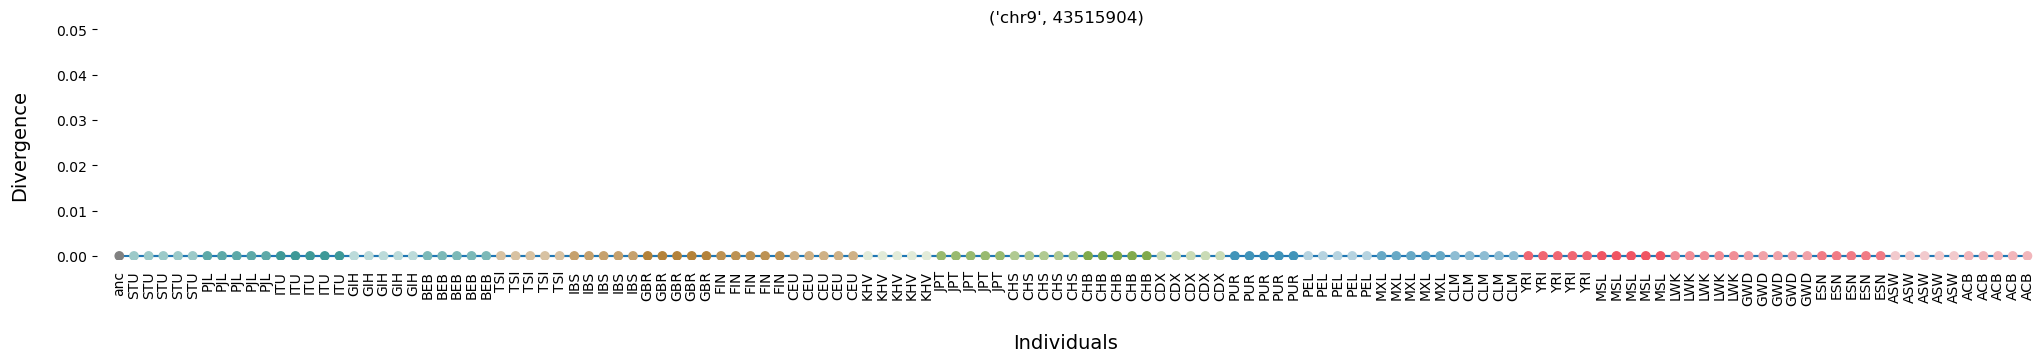

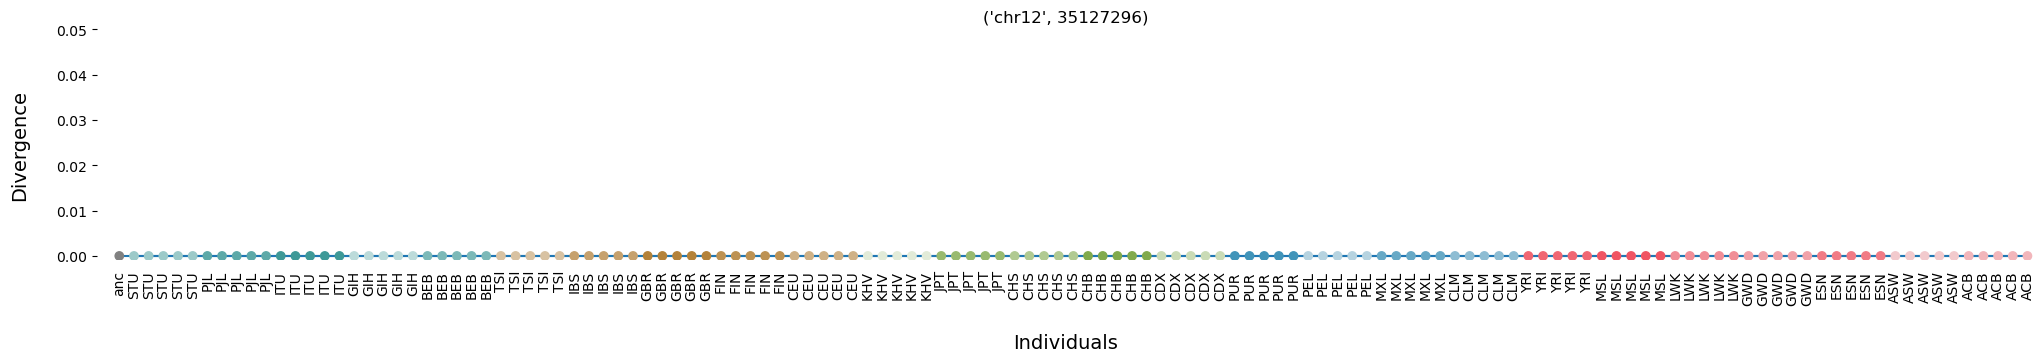

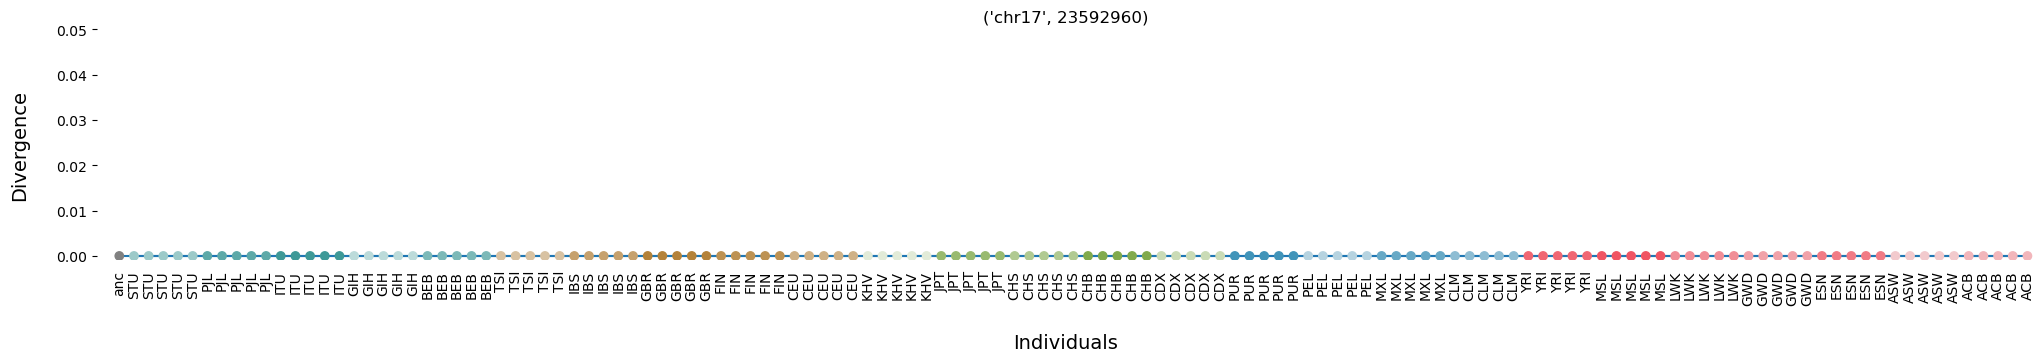

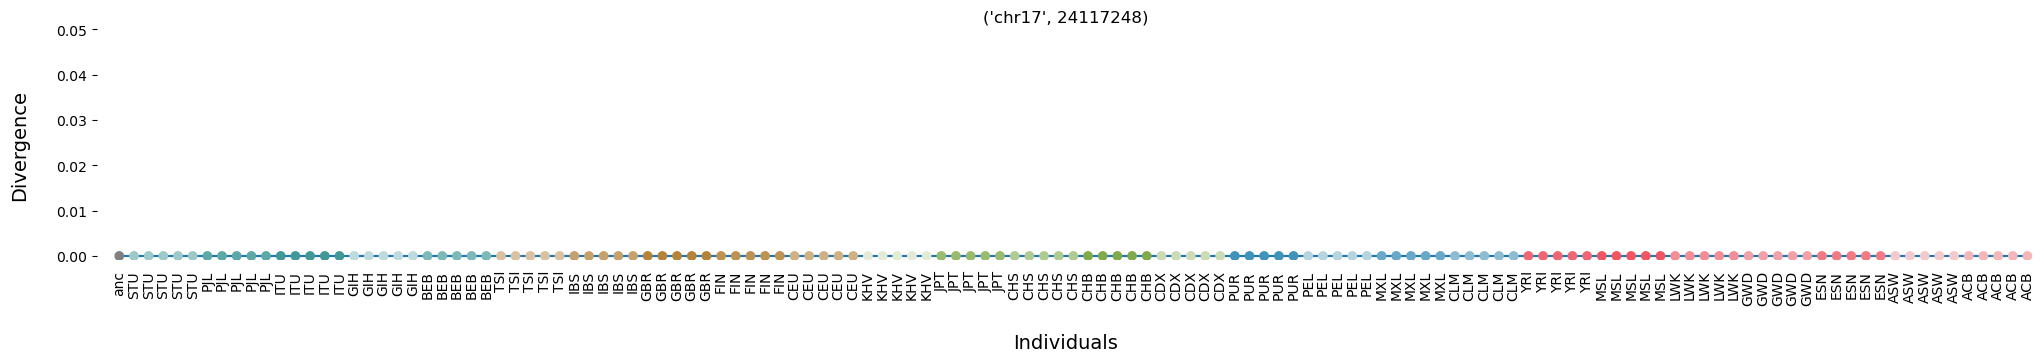

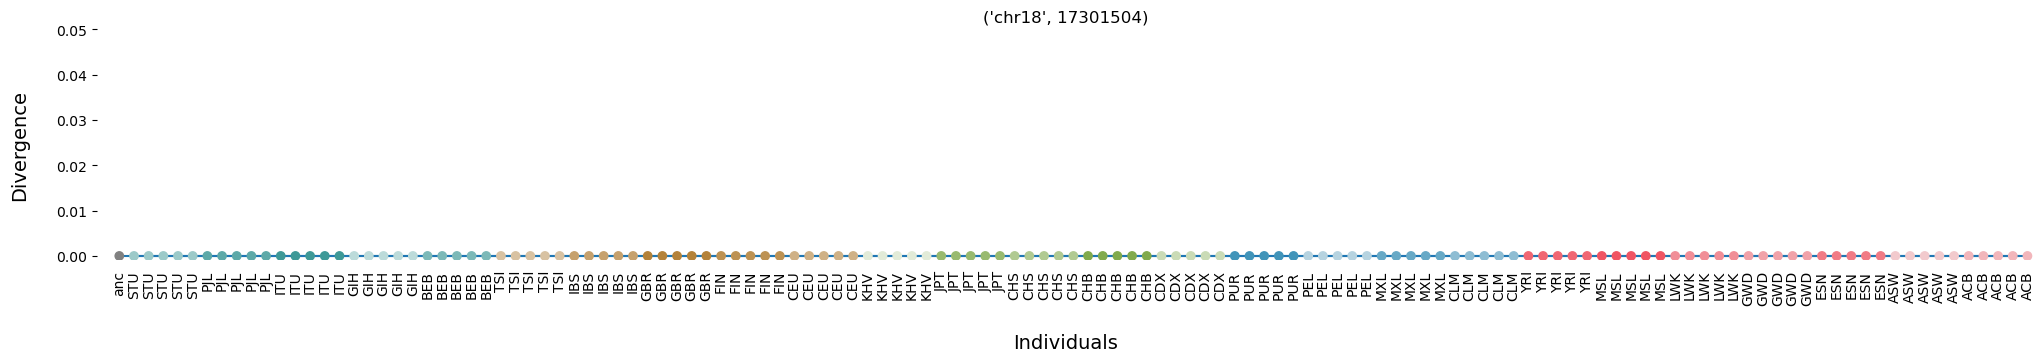

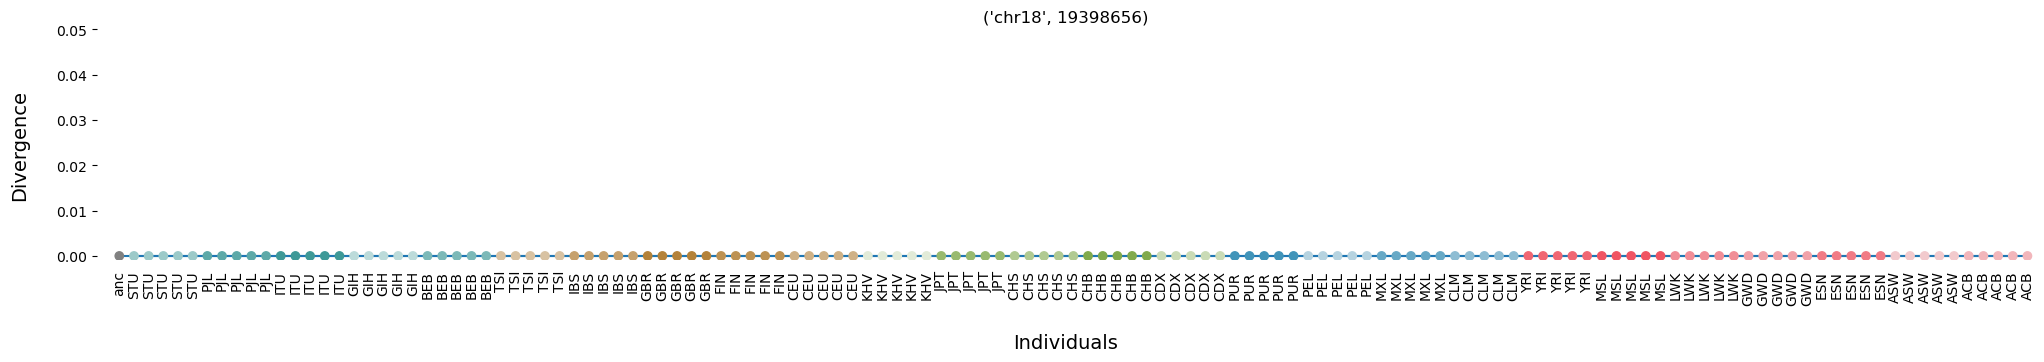

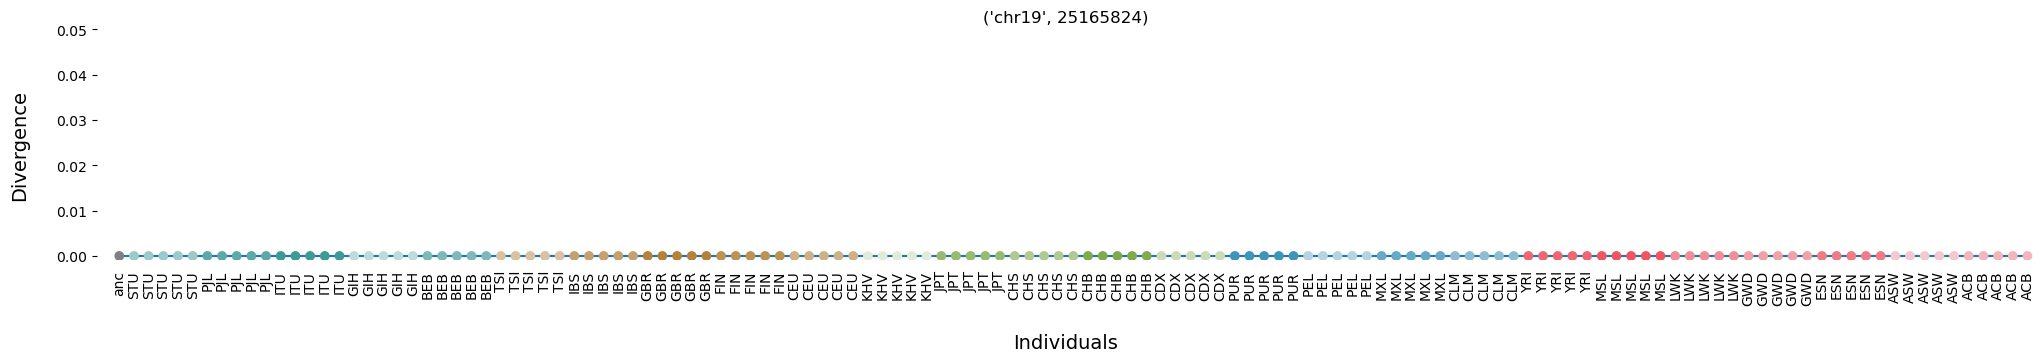

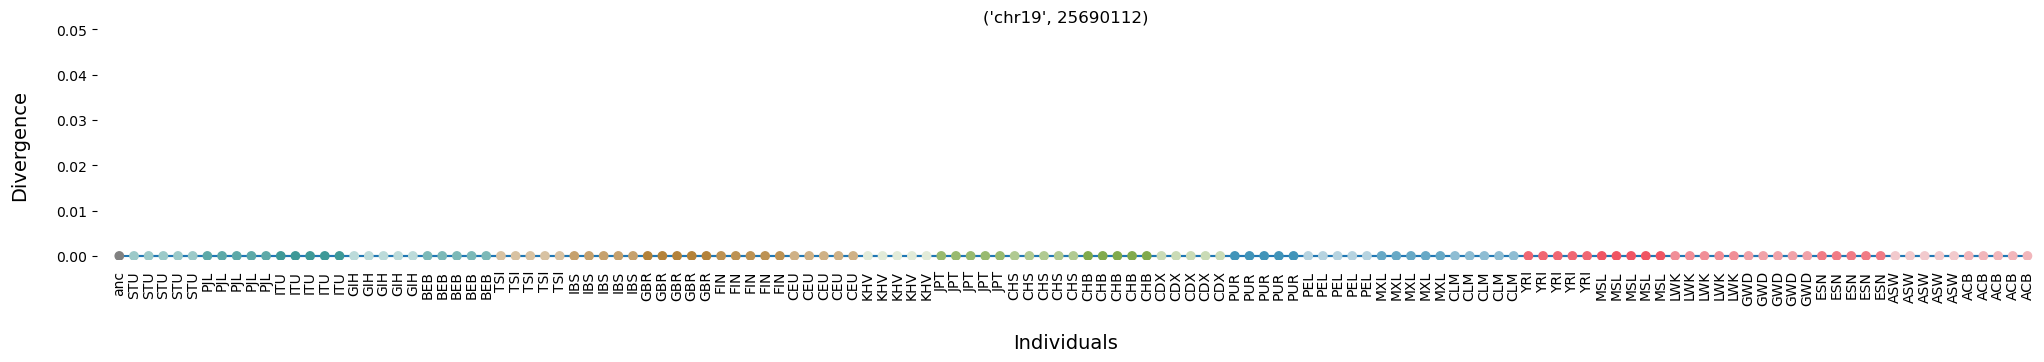

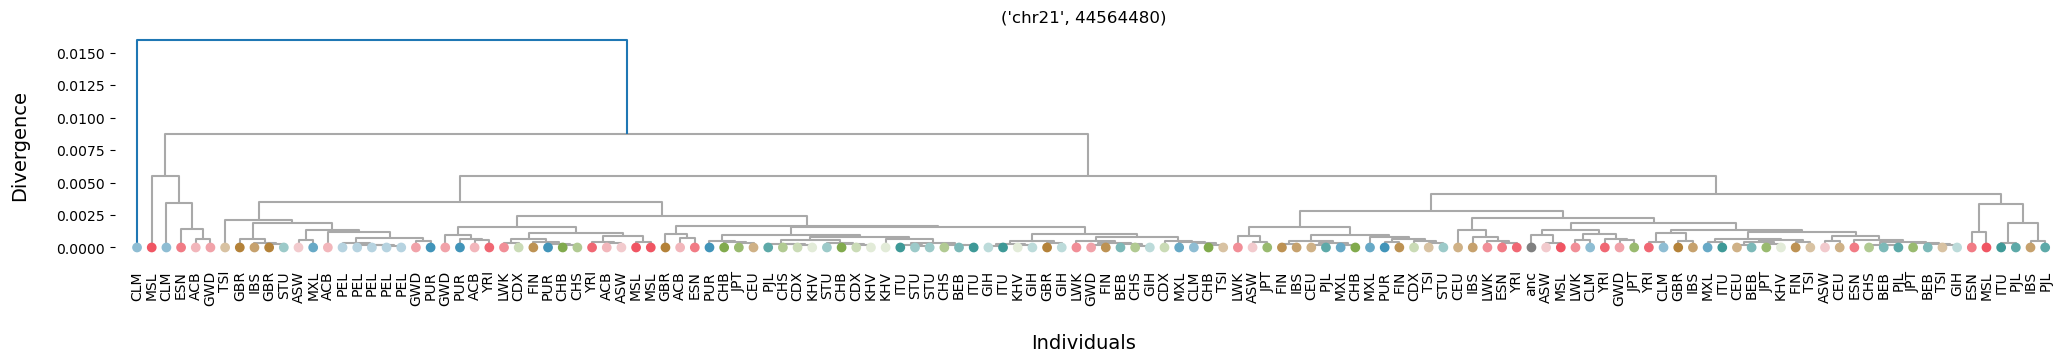

In [57]:
for w in sub_mono[sub_mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [58]:
test.loc[sub_mono[sub_mono.eq(True).any(1)].index]

,C0,C1,C2,C3,C4,C5,depth,pure_super,pure_sub,super,sub,cluster_size,num_clusters
"(chr1, 122683392)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr1, 123207680)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr1, 123731968)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr3, 92274688)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr5, 47710208)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr5, 48234496)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr9, 43515904)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr12, 35127296)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr17, 23592960)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1
"(chr17, 24117248)",131.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,NaN,NaN,131,1


##### Toy example

In [136]:

t =  Tree("((((((a, e), i), o),h), u), ((f, g), j));")
print(t)


                  /-a
               /-|
            /-|   \-e
           |  |
         /-|   \-i
        |  |
      /-|   \-o
     |  |
   /-|   \-h
  |  |
  |   \-u
--|
  |      /-f
  |   /-|
   \-|   \-g
     |
      \-j


In [138]:
t.check_monophyly(values=["a", "e", "i", "o", "u"], target_attr="name")

(False, 'polyphyletic', {Tree node 'h' (0x7ff5f9794ac)})

In [140]:
t.check_monophyly(values=["a", "e", "i", "o"], target_attr="name")

(True, 'monophyletic', set())

In [141]:
t.check_monophyly(values=["i", "o"], target_attr="name")

(False,
 'paraphyletic',
 {Tree node 'a' (0x7ff5f979476), Tree node 'e' (0x7ff5f97947c)})

## Compare trees

In [168]:
w = ('chr1', 1048576)

In [189]:
trees['avg'].compare(trees[w])

{'rf': 254.0,
 'max_rf': 258.0,
 'ref_edges_in_source': 0.015503875968992248,
 'source_edges_in_ref': 0.015503875968992248,
 'effective_tree_size': 131,
 'norm_rf': 0.9844961240310077,
 'treeko_dist': 'NA',
 'source_subtrees': 1,
 'common_edges': {('AFR_ACB_female_HG01896',
   'AFR_ACB_female_HG02095',
   'AFR_ACB_female_HG02337',
   'AFR_ACB_female_HG02505',
   'AFR_ACB_female_HG02555',
   'AFR_ASW_female_NA19625',
   'AFR_ASW_female_NA19901',
   'AFR_ASW_female_NA19917',
   'AFR_ASW_female_NA20314',
   'AFR_ASW_female_NA20317',
   'AFR_ESN_female_HG02946',
   'AFR_ESN_female_HG02974',
   'AFR_ESN_female_HG03111',
   'AFR_ESN_female_HG03159',
   'AFR_ESN_female_HG03511',
   'AFR_GWD_female_HG02635',
   'AFR_GWD_female_HG02679',
   'AFR_GWD_female_HG02814',
   'AFR_GWD_female_HG02879',
   'AFR_GWD_female_HG02888',
   'AFR_LWK_female_NA19024',
   'AFR_LWK_female_NA19037',
   'AFR_LWK_female_NA19314',
   'AFR_LWK_female_NA19446',
   'AFR_LWK_female_NA19457',
   'AFR_MSL_female_HG03086',


In [ ]:
tree_comp_stats = pd.DataFrame(index = windows_tuples, columns=['norm_rf','ref_edges_in_source','source_edges_in_ref'])
for w in trees.keys():
    comp = trees['avg'].compare(trees[w]).keys()
    norm = comp['norm_rf']
    rs = comp['ref_edges_in_source']
    sr = comp['source_edges_in_ref']
    

In [193]:
tree_comp_stats = pd.DataFrame(index = windows_tuples, columns=['norm_rf','ref_edges_in_source','source_edges_in_ref'])
comp = trees['avg'].compare(trees[w])
norm = comp['norm_rf']
rs = comp['ref_edges_in_source']
sr = comp['source_edges_in_ref']

In [199]:
w

('chr1', 1048576)

In [201]:
tree_comp_stats.loc[[w]] = pd.Series([norm, rs, sr])

In [203]:
tree_comp_stats.loc[[w]]

,norm_rf,ref_edges_in_source,source_edges_in_ref
"(chr1, 1048576)",NaN,NaN,NaN


In [192]:
pd.Series([norm, rs, sr])

0    0.984496
1    0.015504
2    0.015504
dtype: float64

# Hist for Colin

In [12]:
comp_list_div = pd.read_csv('/Users/egilbertson/Box Sync/UCSF/CapraLab/3DGenome/dowloads/comp_tables/pairwise_subsample_divergence_per_region.csv',
                       index_col=0, header=[0,1])

KeyboardInterrupt: 

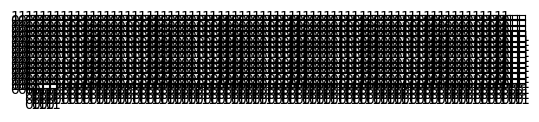

In [17]:
comp_list_div.hist()

In [23]:
vals = comp_list_div.drop(columns=['comparison'])

KeyboardInterrupt: 

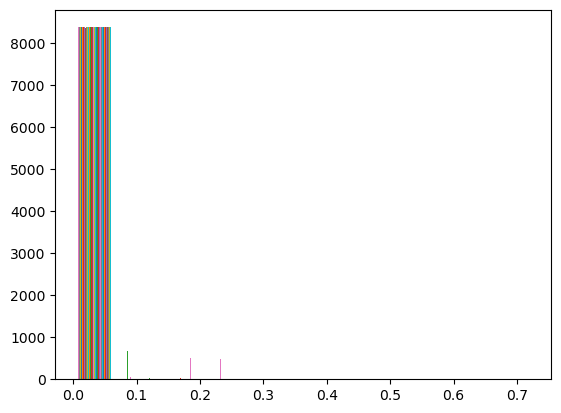

In [36]:
plt.hist(vals.values)
plt.xlabel()
plt.ylabel()
plt.title('Modern Human 3D Divergence')

In [44]:
np.array(vals)

array([[0.00291628, 0.00264164, 0.00402892, ..., 0.00984255, 0.02099248,
        0.00500303],
       [0.00336759, 0.00311313, 0.00165062, ..., 0.00287003, 0.00545249,
        0.00767578],
       [0.00561597, 0.00574114, 0.00579626, ..., 0.00924235, 0.01413046,
        0.00975827],
       ...,
       [0.00035745, 0.00125918, 0.00399662, ..., 0.02051836, 0.11568521,
        0.00392209],
       [0.00154935, 0.00196315, 0.00619017, ..., 0.04797375, 0.06117338,
        0.00296156],
       [0.00121208, 0.00235829, 0.01109772, ..., 0.09203002, 0.26346068,
        0.00227247]])

(0.0, 0.05)

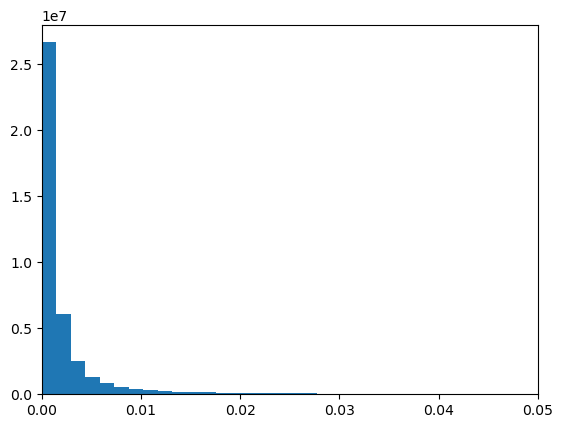

In [49]:
plt.hist(vals.to_numpy().flatten(), bins=500)
plt.xlim(0,.05)

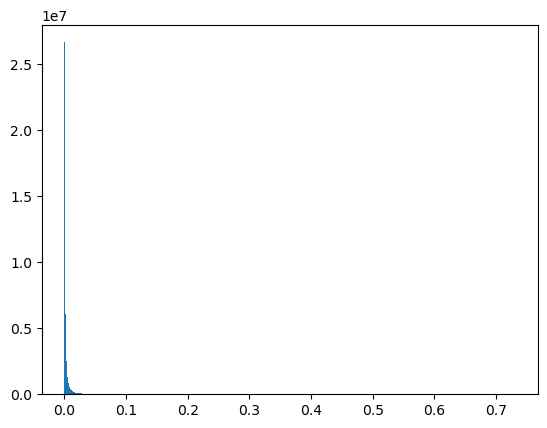

In [51]:
a = plt.hist(vals.to_numpy().flatten(), bins=500)

In [56]:
a[1]


array([0.        , 0.0014624 , 0.00292479, 0.00438719, 0.00584958,
       0.00731198, 0.00877438, 0.01023677, 0.01169917, 0.01316157,
       0.01462396, 0.01608636, 0.01754875, 0.01901115, 0.02047355,
       0.02193594, 0.02339834, 0.02486074, 0.02632313, 0.02778553,
       0.02924792, 0.03071032, 0.03217272, 0.03363511, 0.03509751,
       0.03655991, 0.0380223 , 0.0394847 , 0.04094709, 0.04240949,
       0.04387189, 0.04533428, 0.04679668, 0.04825908, 0.04972147,
       0.05118387, 0.05264626, 0.05410866, 0.05557106, 0.05703345,
       0.05849585, 0.05995825, 0.06142064, 0.06288304, 0.06434543,
       0.06580783, 0.06727023, 0.06873262, 0.07019502, 0.07165741,
       0.07311981, 0.07458221, 0.0760446 , 0.077507  , 0.0789694 ,
       0.08043179, 0.08189419, 0.08335658, 0.08481898, 0.08628138,
       0.08774377, 0.08920617, 0.09066857, 0.09213096, 0.09359336,
       0.09505575, 0.09651815, 0.09798055, 0.09944294, 0.10090534,
       0.10236774, 0.10383013, 0.10529253, 0.10675492, 0.10821

# GAGP Ancestral

In [ ]:
preds_loc = '/wynton/group/capra/projects/modern_human_3Dgenome/data/akitaPreds/3dpreds/HFF_original/3dpreds_GAGP_ancestral.txt'
pairwise_loc = '/wynton/group/capra/projects/modern_human_3Dgenome/data/pairwise/gagp'